In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import json
import math
import os
import socket
import sys
import time
import datetime
import uuid
from argparse import ArgumentParser
import setproctitle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection
import json

internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from utils.eval import evaluate, validation_and_agreement, distance_models, evaluate_regression,hellinger


from sklearn.datasets import *
from sklearn import linear_model



/local/home/glanzillo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluating the distribution of |t(x) - y| 

In [30]:
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from torch.utils.data import ConcatDataset

DEVICE=[3]
CHKPT_NAME = "rn50_2023-02-21_10-45-30_best.ckpt"
TRAIN_SUBSET = 500000

device = get_device(DEVICE)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=",".join([str(d) for d in DEVICE])



In [28]:
def load_checkpoint(device, best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath, map_location=device)
          if filename==CHKPT_NAME and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [29]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [34]:
all_indices = set(range(len(train_dataset)))
random_indices = np.random.choice(list(all_indices), size=TRAIN_SUBSET, replace=False)
train_subset = Subset(train_dataset, random_indices)
train_subset_loader =  DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)


In [32]:
# loading the teacher
teacher = resnet50(weights=None)
checkpoint = load_checkpoint(device, best=False, filename=CHKPT_NAME, distributed=False) 
teacher.load_state_dict(checkpoint['state_dict'])
teacher.to(device)
teacher.eval();

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


In [52]:

is_train = True
loader = train_subset_loader if is_train else val_loader
filename = "FDIST_T" + "_test.txt" if not is_train else "FDIST_T.txt"
path = base_path() + "results" + "/" + "imagenet" + "/" + "resnet50" +"/"

start = time.time()
progress_bar = ProgressBar(verbose=True)
for i,data in enumerate(loader):
        with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                labels = F.one_hot(labels, num_classes=1000).to(torch.float)
                outputs_t = F.softmax(teacher(inputs),dim=1)
                distance_l = hellinger(outputs_t,labels).tolist()
                
        progress_bar.prog(i, len(loader), 'Teacher distance', 'train data' if is_train else 'val data', distance_l[0])
        
        distance_log = {}
        distance_log['batch'] = i
        distance_log['data_points'] = TRAIN_SUBSET if is_train else len(val_dataset)
        distance_log['test'] = not is_train

        for d_l in  distance_l: 
                dict = distance_log
                dict['distance'] = d_l
                with open(path+ filename, 'a') as f:
                        f.write(json.dumps(dict) + '\n')

end = time.time()

[ 10-18 | 12:02 ] Task train data | epoch Teacher distance: |██████████████████████████████████████████████████| 2.13 ep/h | loss: 0.12778176 |

# Looking at the results

# Teacher error distribution

In [44]:
logs_path = './logs/results/imagenet/resnet50/FDIST_T_test.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
teacher_df_test = pd.DataFrame(results)
teacher_df_test

batch  data_points  test  distance
0          0        50000  True  0.064461
1          0        50000  True  0.397264
2          0        50000  True  0.770162
3          0        50000  True  0.112927
4          0        50000  True  0.088759
...      ...          ...   ...       ...
49995    390        50000  True  0.063526
49996    390        50000  True  0.423267
49997    390        50000  True  0.038703
49998    390        50000  True  0.721289
49999    390        50000  True  0.925834

[50000 rows x 4 columns]

In [53]:
logs_path = './logs/results/imagenet/resnet50/FDIST_T.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
teacher_df_train = pd.DataFrame(results)
teacher_df_train

batch  data_points   test  distance
0           0       500000  False  0.818439
1           0       500000  False  0.820787
2           0       500000  False  0.172395
3           0       500000  False  0.073756
4           0       500000  False  0.000979
...       ...          ...    ...       ...
499995   3906       500000  False  0.930771
499996   3906       500000  False  0.702606
499997   3906       500000  False  0.913845
499998   3906       500000  False  0.216647
499999   3906       500000  False  0.661489

[500000 rows x 4 columns]

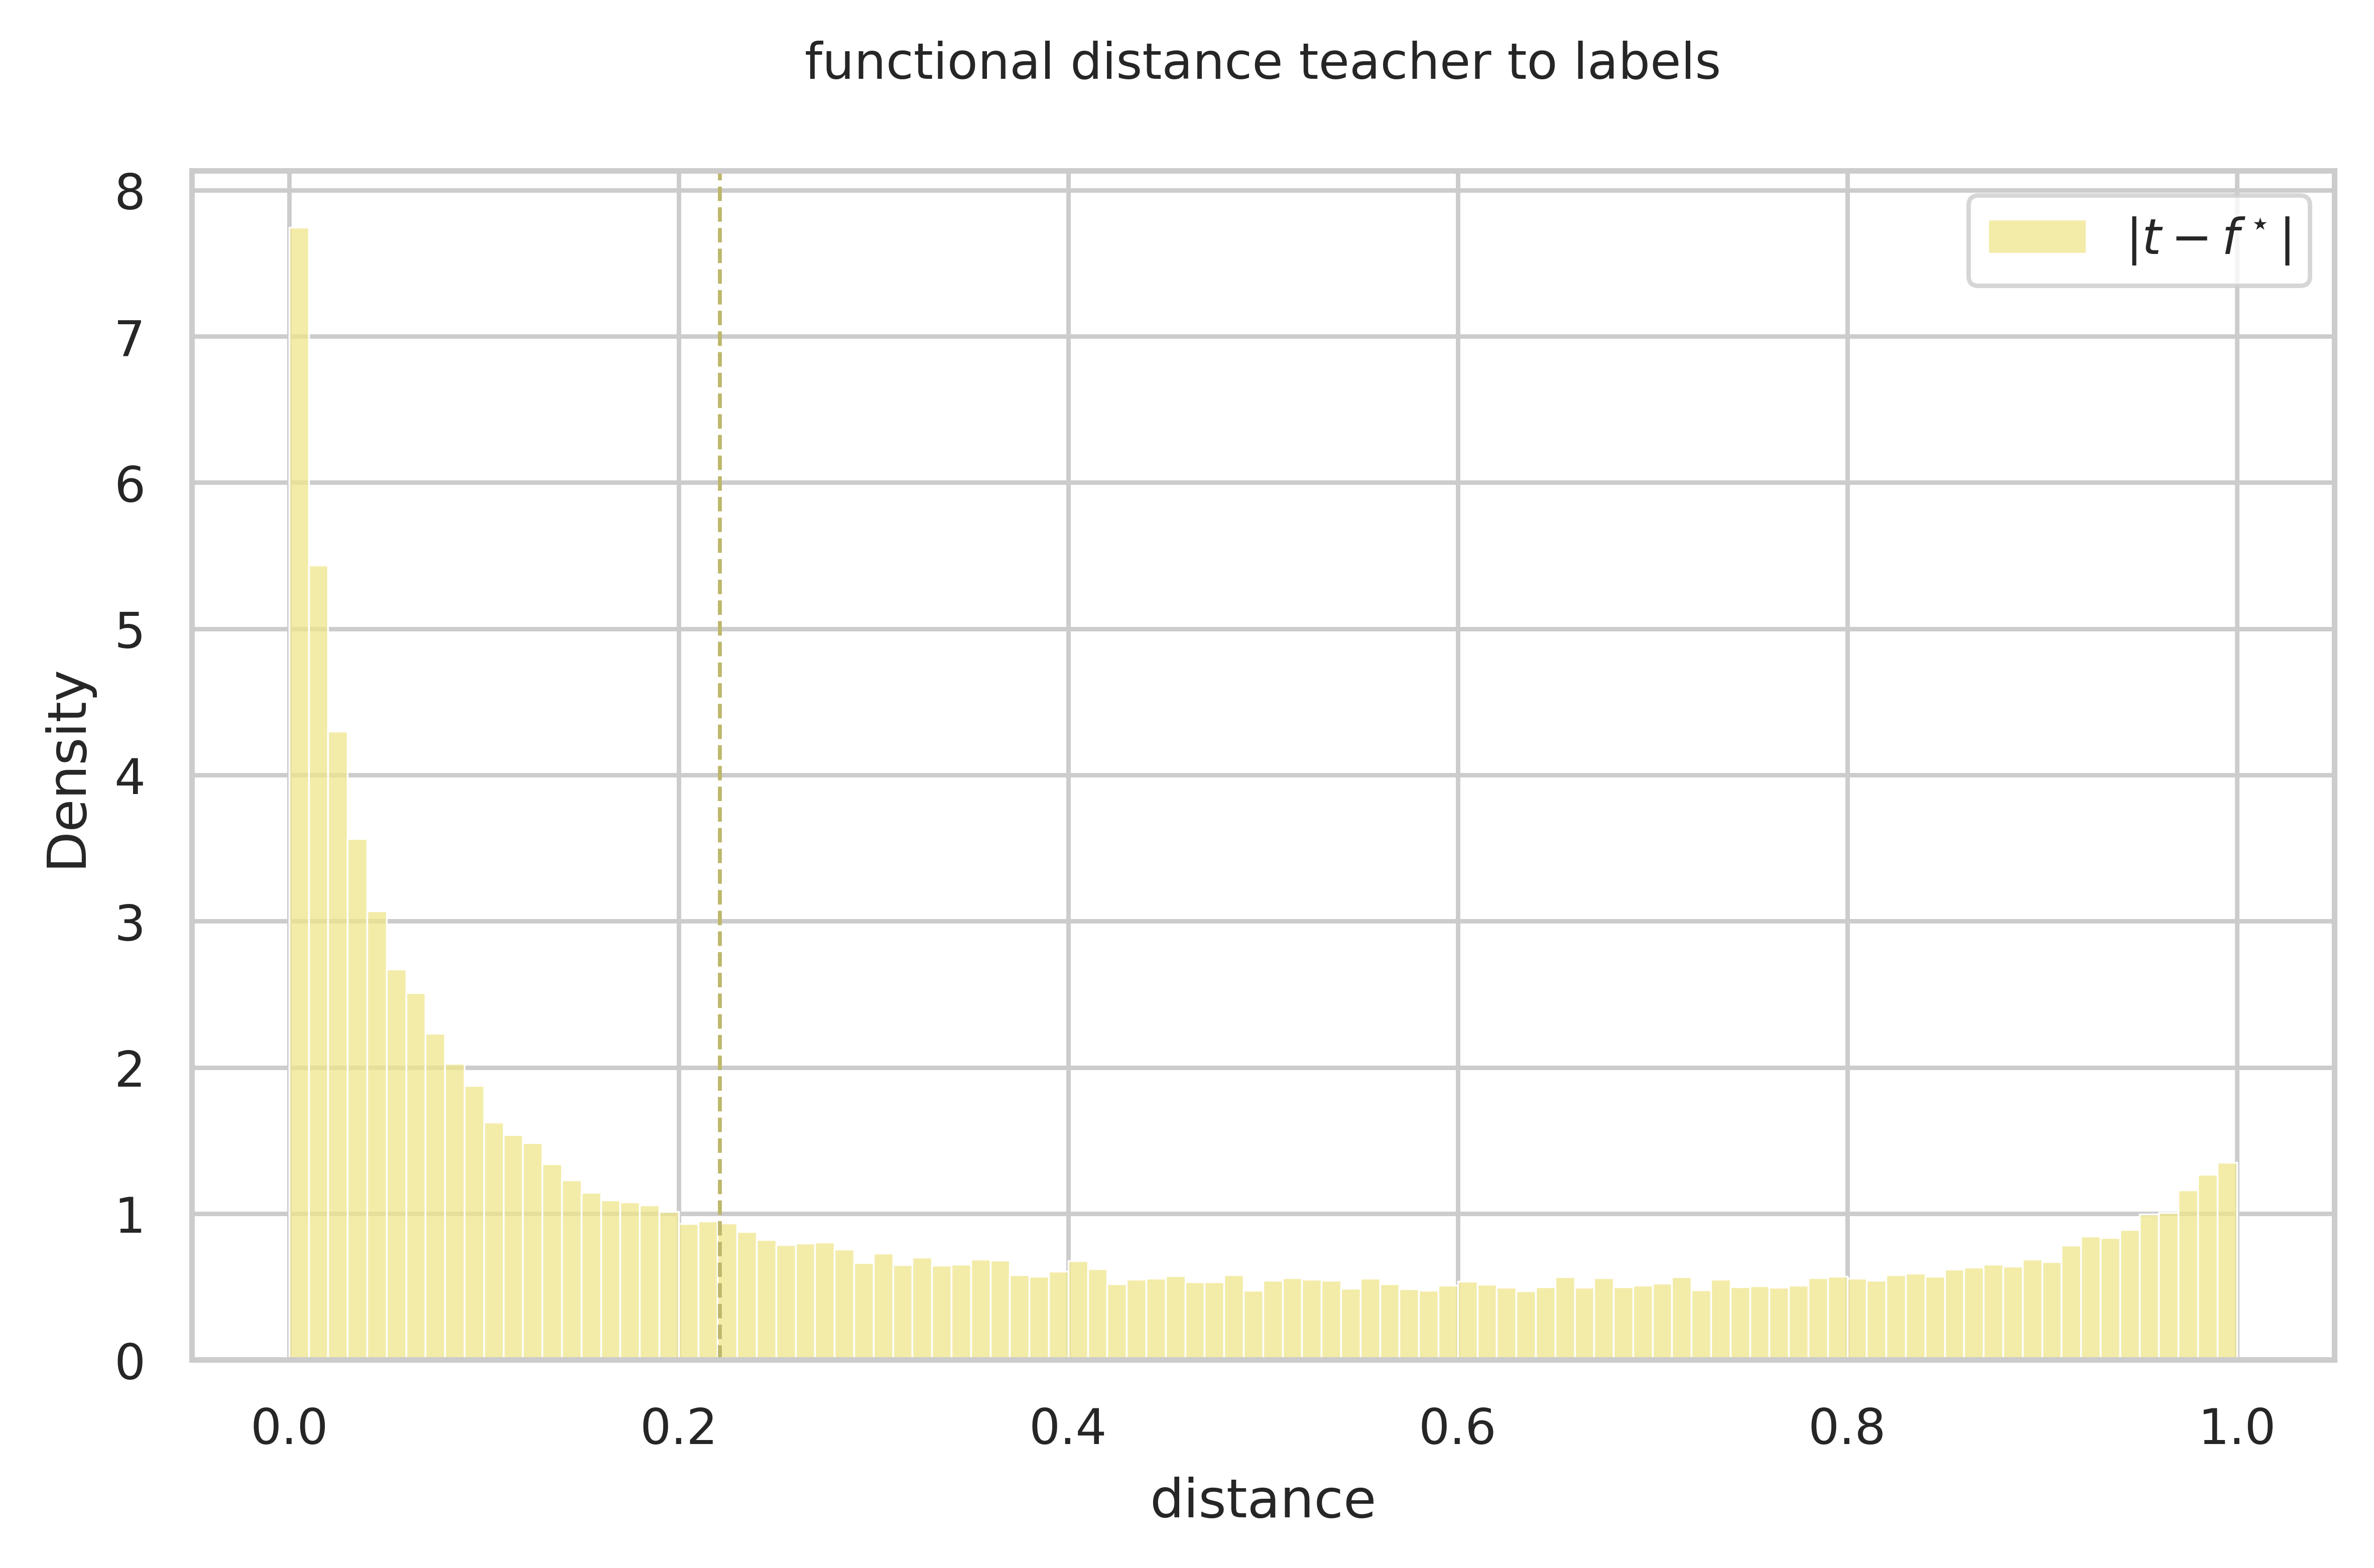

In [45]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    sns.histplot(teacher_df_test, x="distance", ax=ax, color=colors[4], label="t", stat="density", bins=100)
    
    ax.axvline(teacher_df_test['distance'].median(), ls='--', color=colors[5], linewidth=0.7)

    ax.set_title(r"functional distance teacher to labels - test data", fontsize=9, y=1.05)


    # refinements ---------------------------
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'$|t-f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


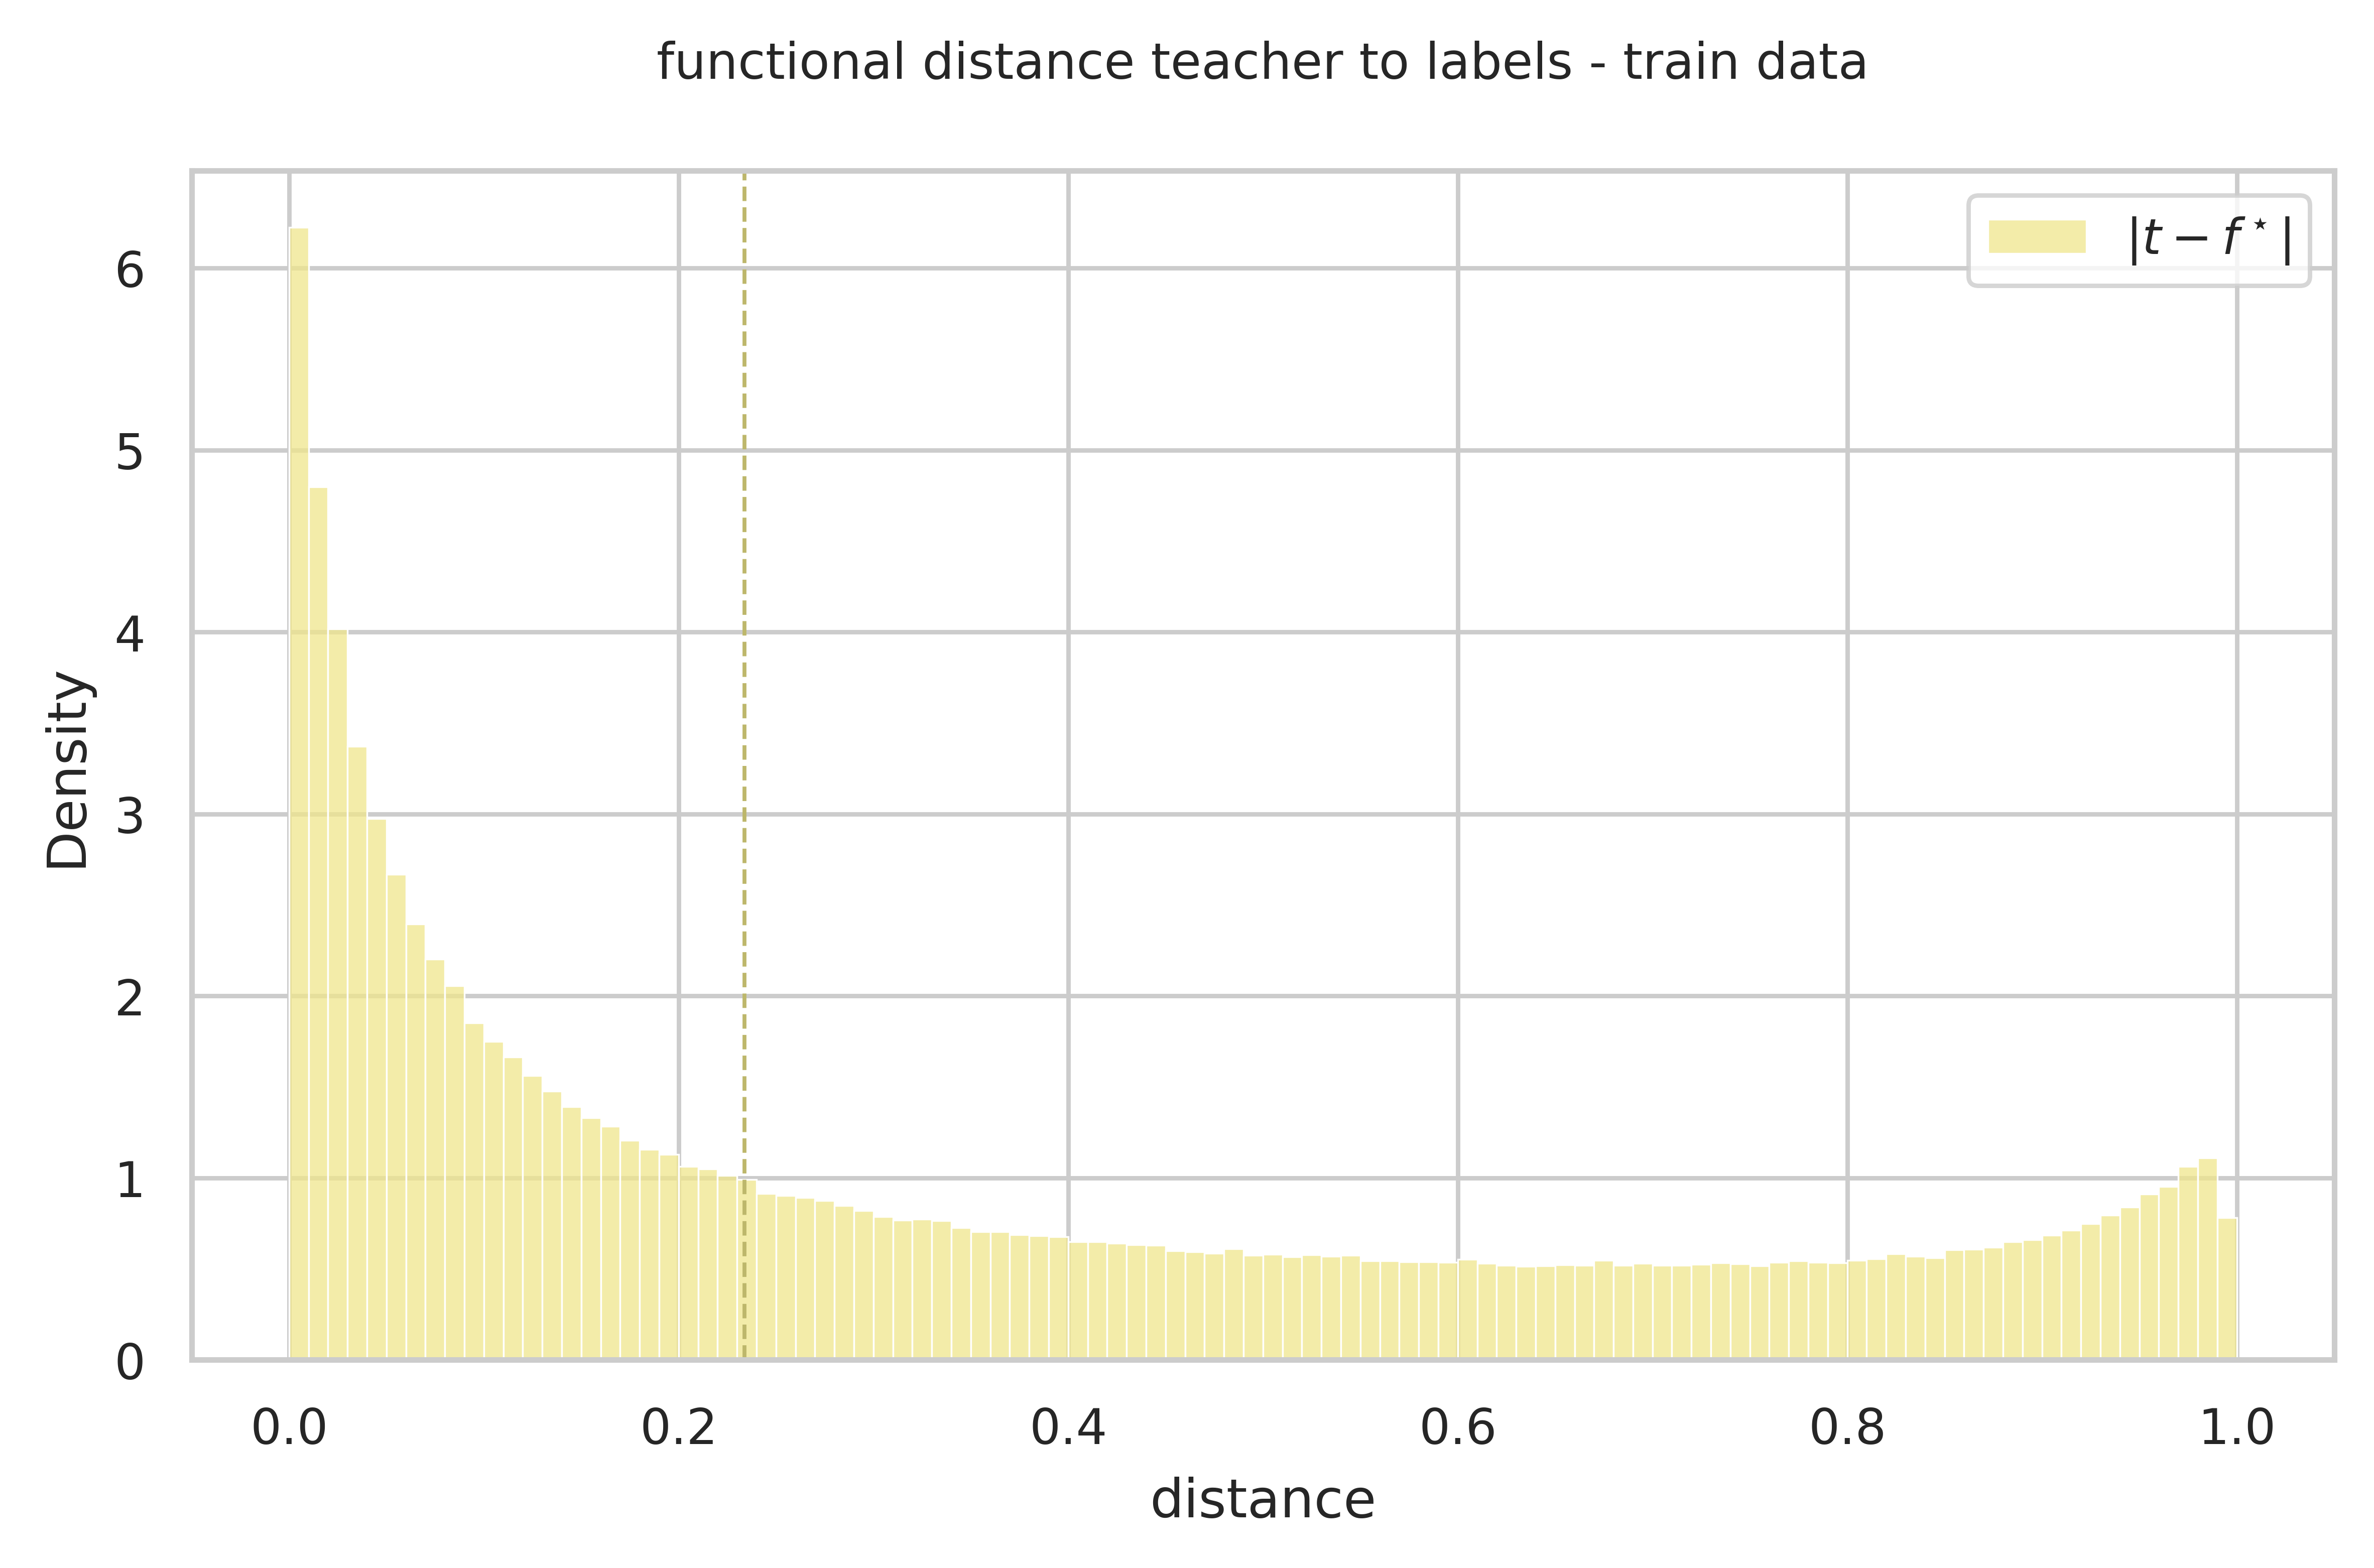

In [54]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    sns.histplot(teacher_df_train, x="distance", ax=ax, color=colors[4], label="t", stat="density", bins=100)
    
    ax.axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)

    ax.set_title(r"functional distance teacher to labels - train data", fontsize=9, y=1.05)


    # refinements ---------------------------
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'$|t-f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


## Test data imagenet

In [47]:
logs_path = './logs/results/imagenet/resnet50/FDIST_test.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

alpha  batch  buffer_size  seed  test  teacher  distance
0          1.0      0        30000    11  True     True  0.738138
1          1.0      0        30000    11  True    False  0.753954
2          1.0      0        30000    11  True     True  0.893558
3          1.0      0        30000    11  True    False  0.991833
4          1.0      0        30000    11  True     True  0.698232
...        ...    ...          ...   ...   ...      ...       ...
1199995    0.0    390        90000    21  True    False  0.138244
1199996    0.0    390        90000    21  True     True  0.131351
1199997    0.0    390        90000    21  True    False  0.409921
1199998    0.0    390        90000    21  True     True  0.212035
1199999    0.0    390        90000    21  True    False  0.612740

[1200000 rows x 7 columns]

In [4]:
res_df['buffer_size'].unique()

array([30000, 90000])

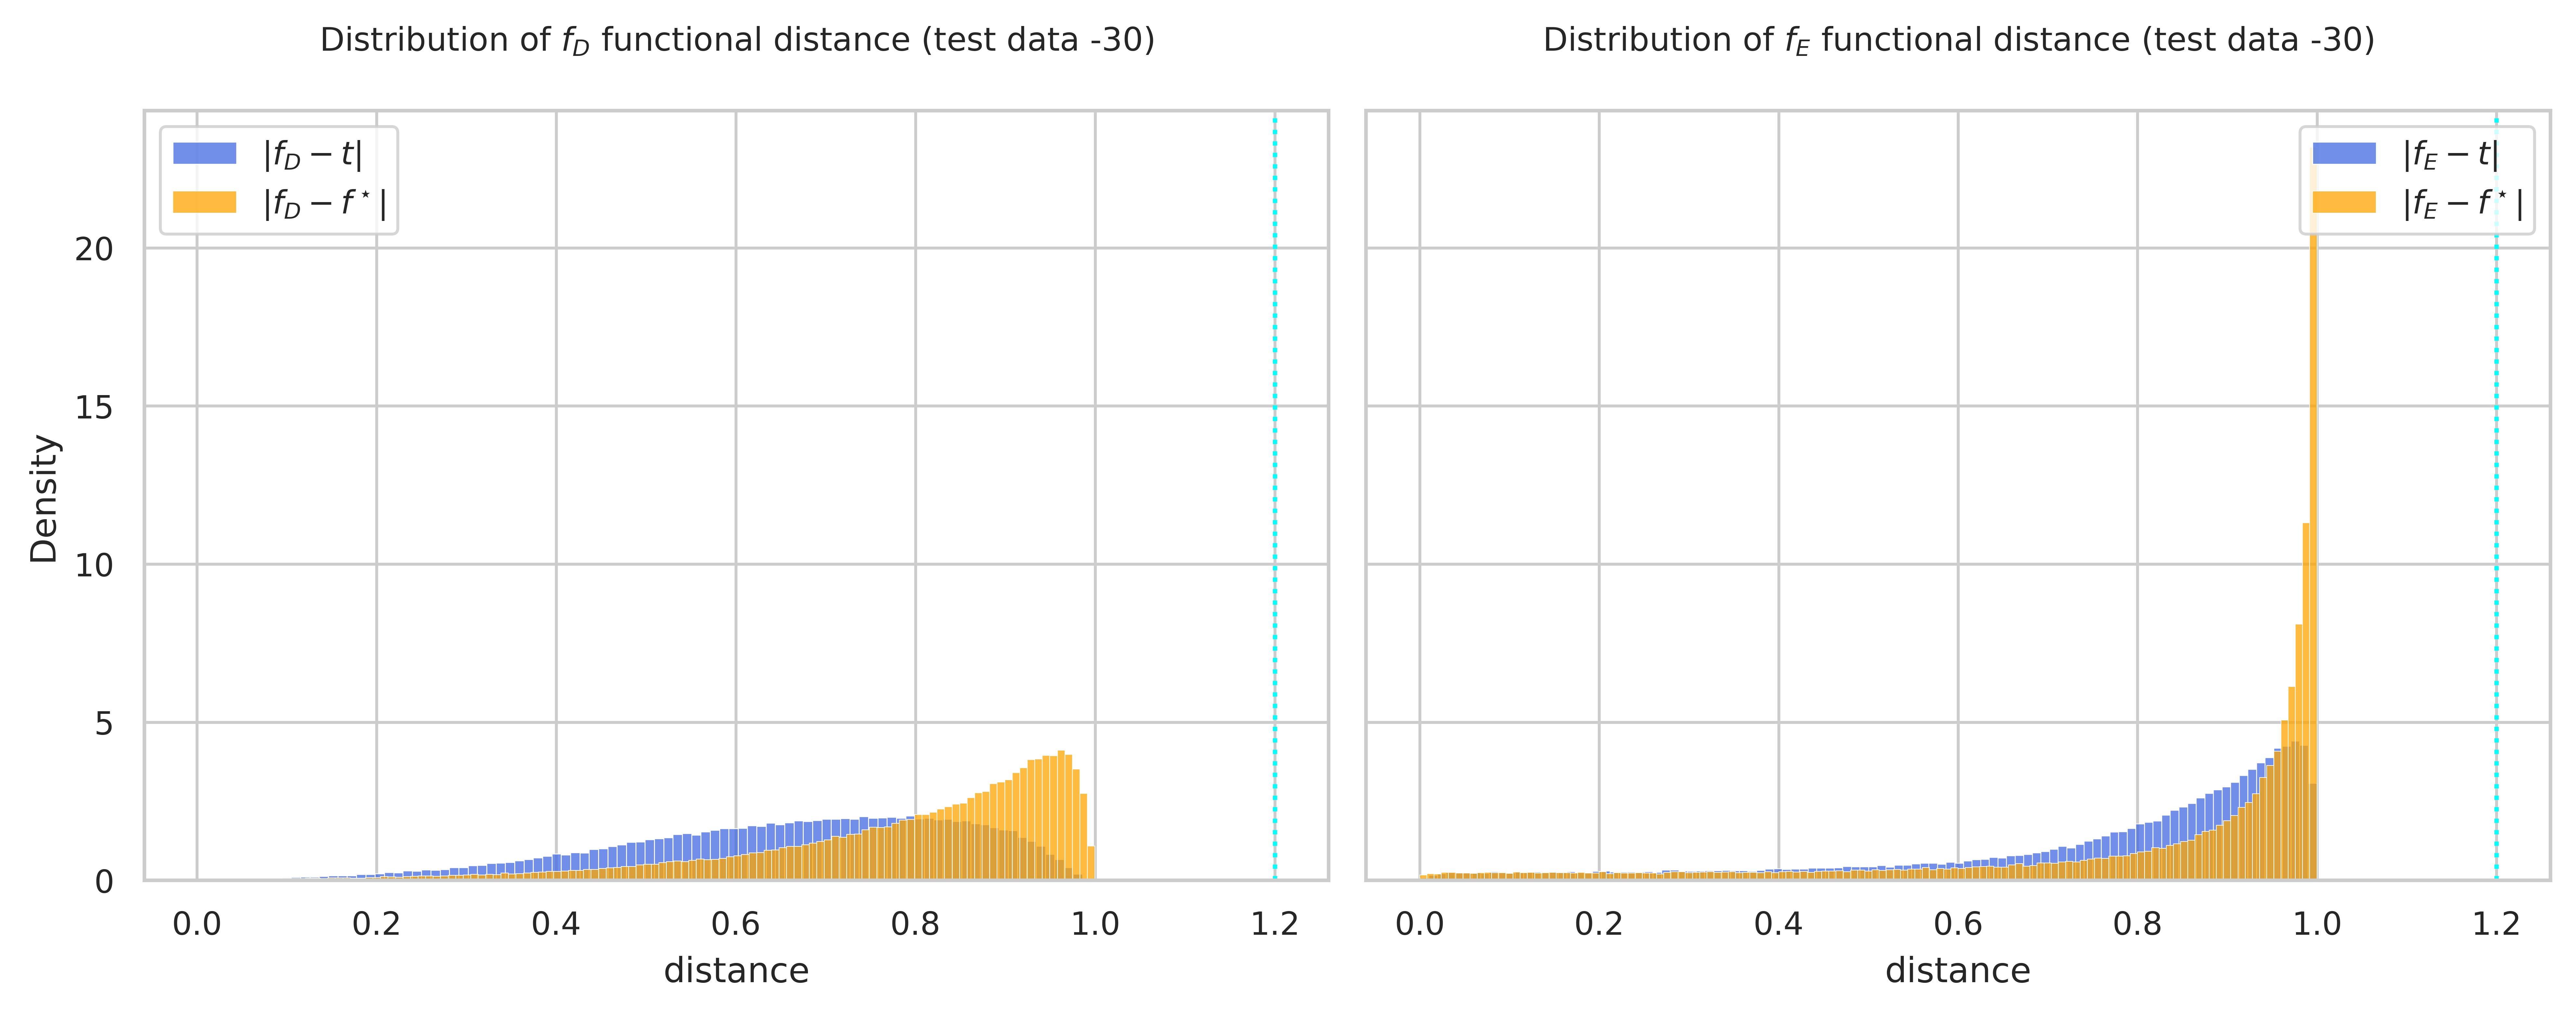

In [5]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    # first plot ---------------------------
    _df = res_df.loc[res_df['alpha']==0]
    _df = _df.loc[_df['buffer_size']==30000]


    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label="test", stat="density")

    ax[0].axvline(1.20, ls=':', color='aqua')


    ax[0].set_title(r"Distribution of $f_D$ functional distance (test data -30)", fontsize=9, y=1.05)
    

    # second plot ---------------------------
    _df = res_df.loc[res_df['alpha']==1]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label="test", stat="density")

    ax[1].axvline(1.20, ls=':', color='aqua')
    ax[1].set_title(r"Distribution of $f_E$ functional distance (test data -30)", fontsize=9, y=1.05)
    

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")
    ax[1].legend(h, [r'$|f_E - t|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


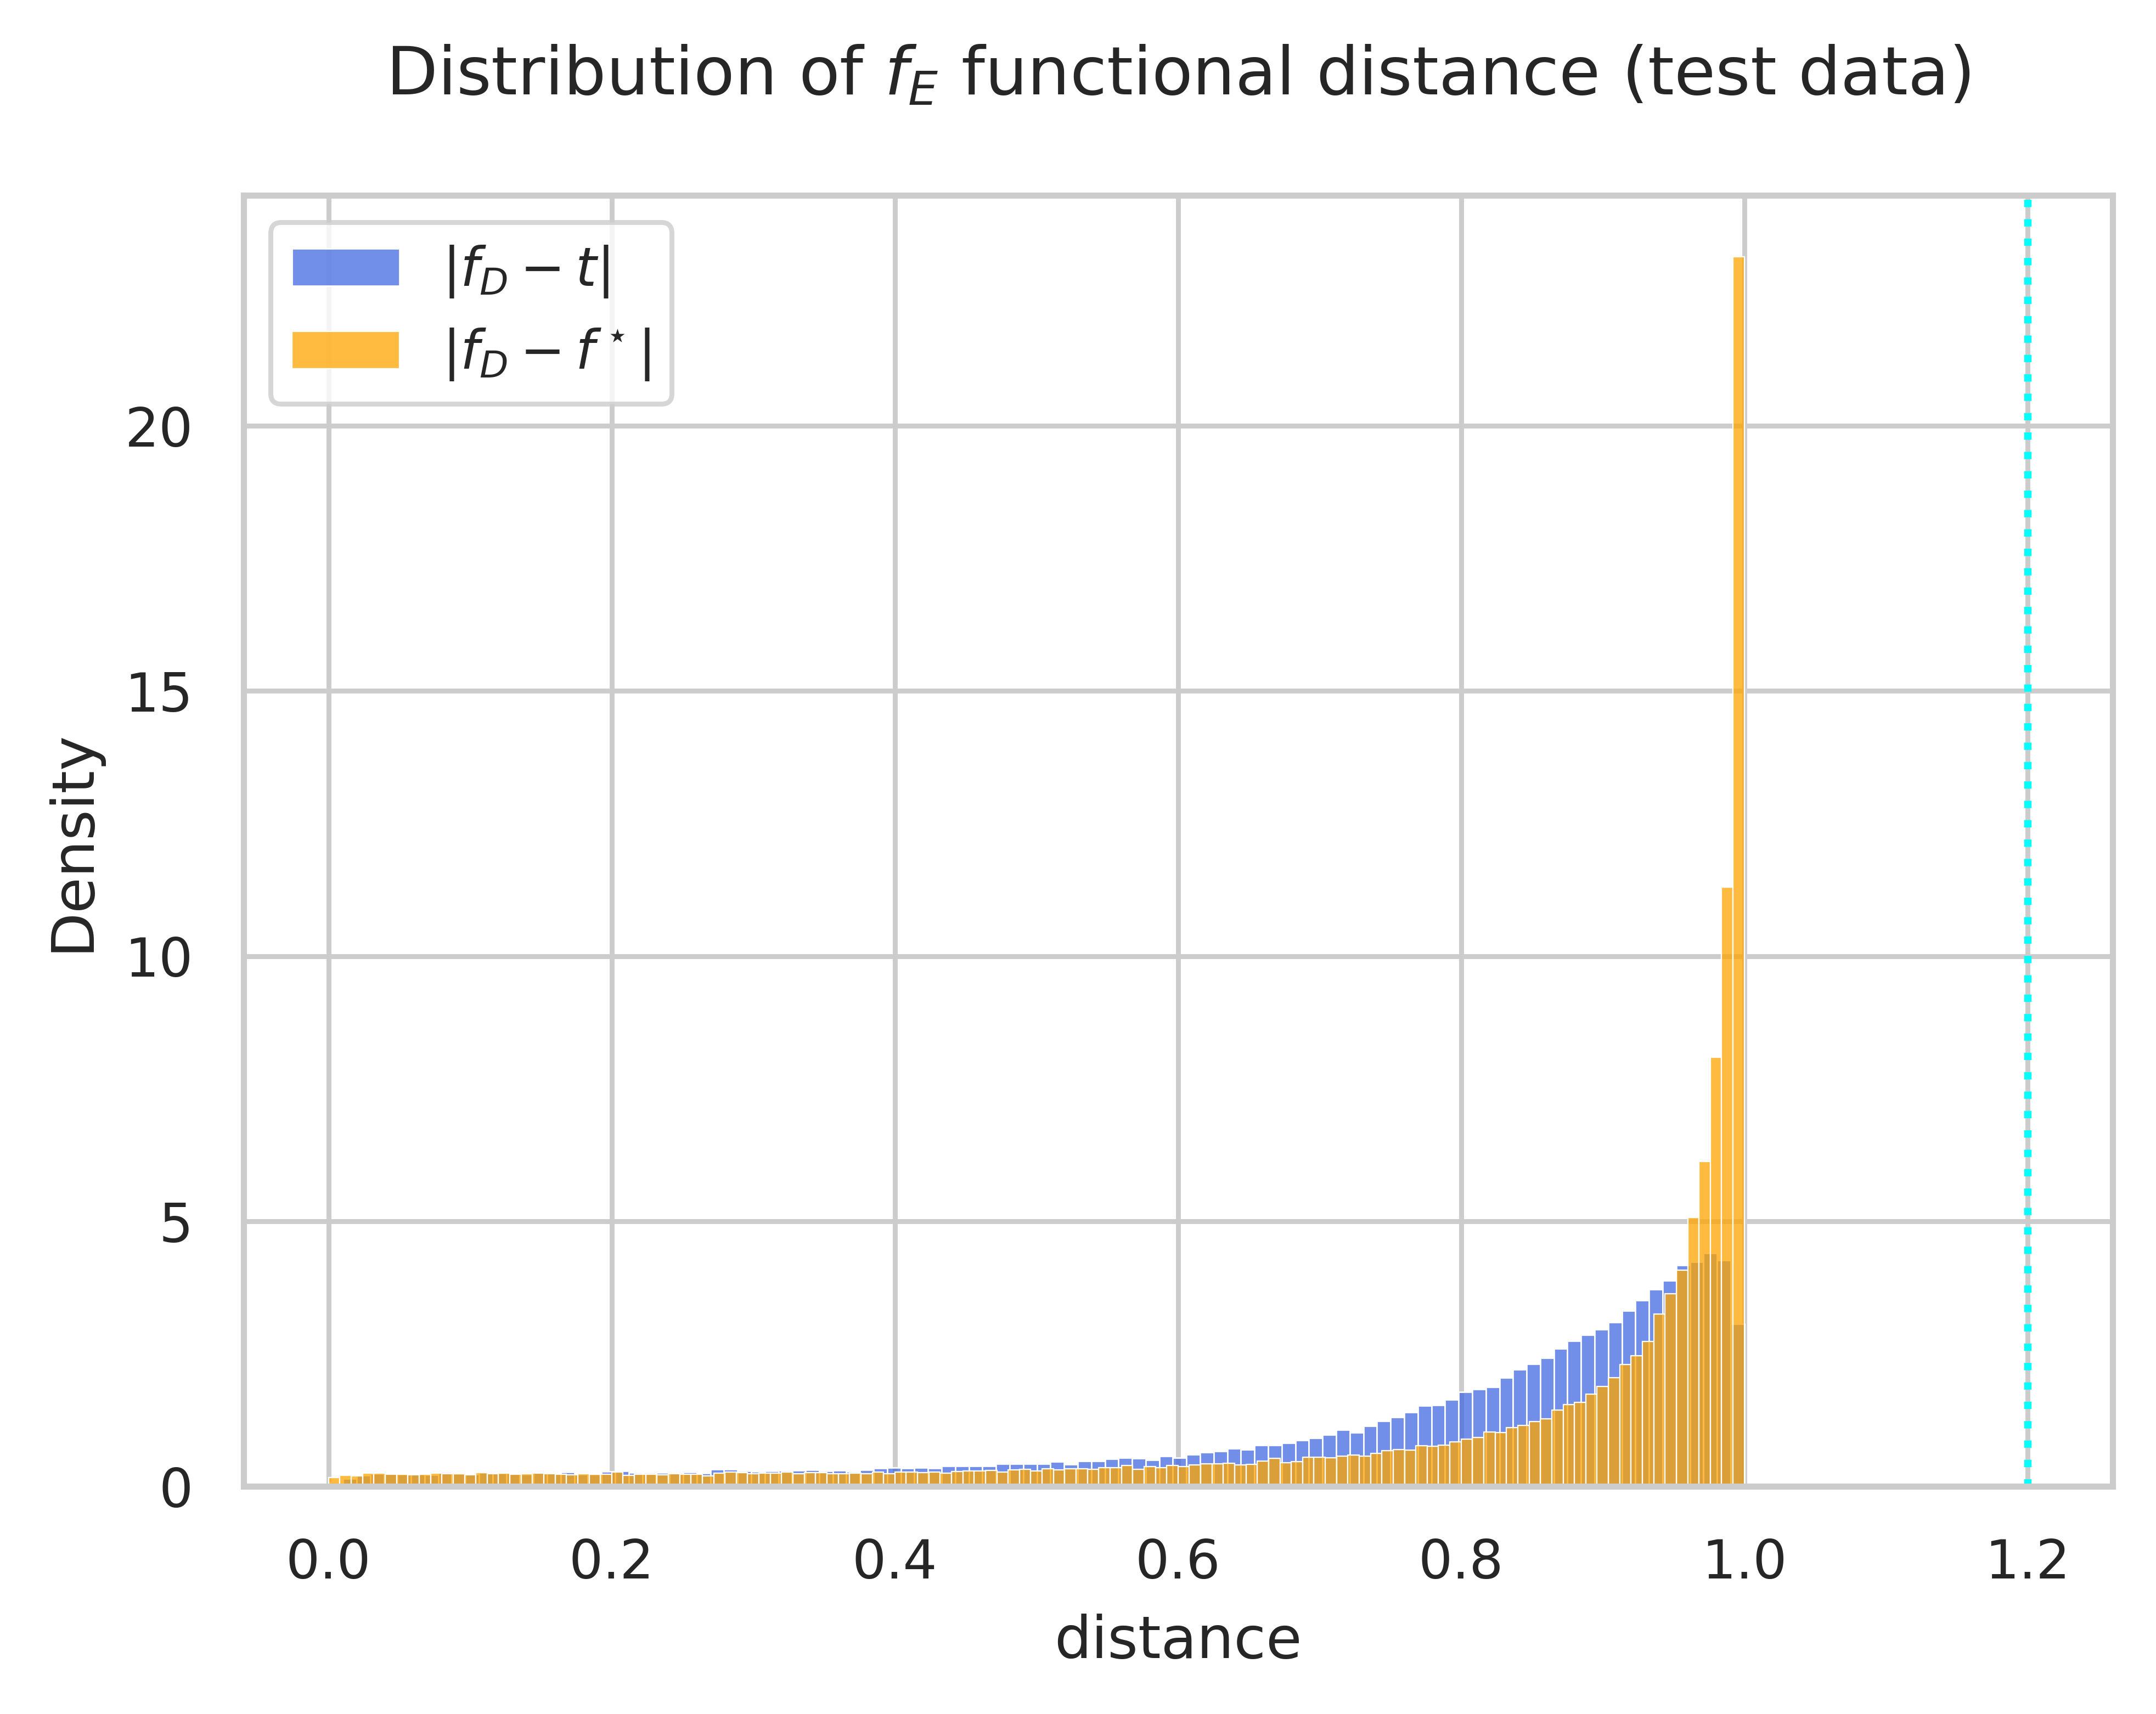

In [6]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    _df = res_df.loc[res_df['alpha']==1]
    _df = _df.loc[_df['buffer_size']==30000]


    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax, color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax, color=colors[1], label="test", stat="density")

    ax.set_title(r"Distribution of $f_E$ functional distance (test data)", fontsize=11, y=1.05)
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")

    ax.axvline(1.20, ls=':', color='aqua')

    
    plt.tight_layout()


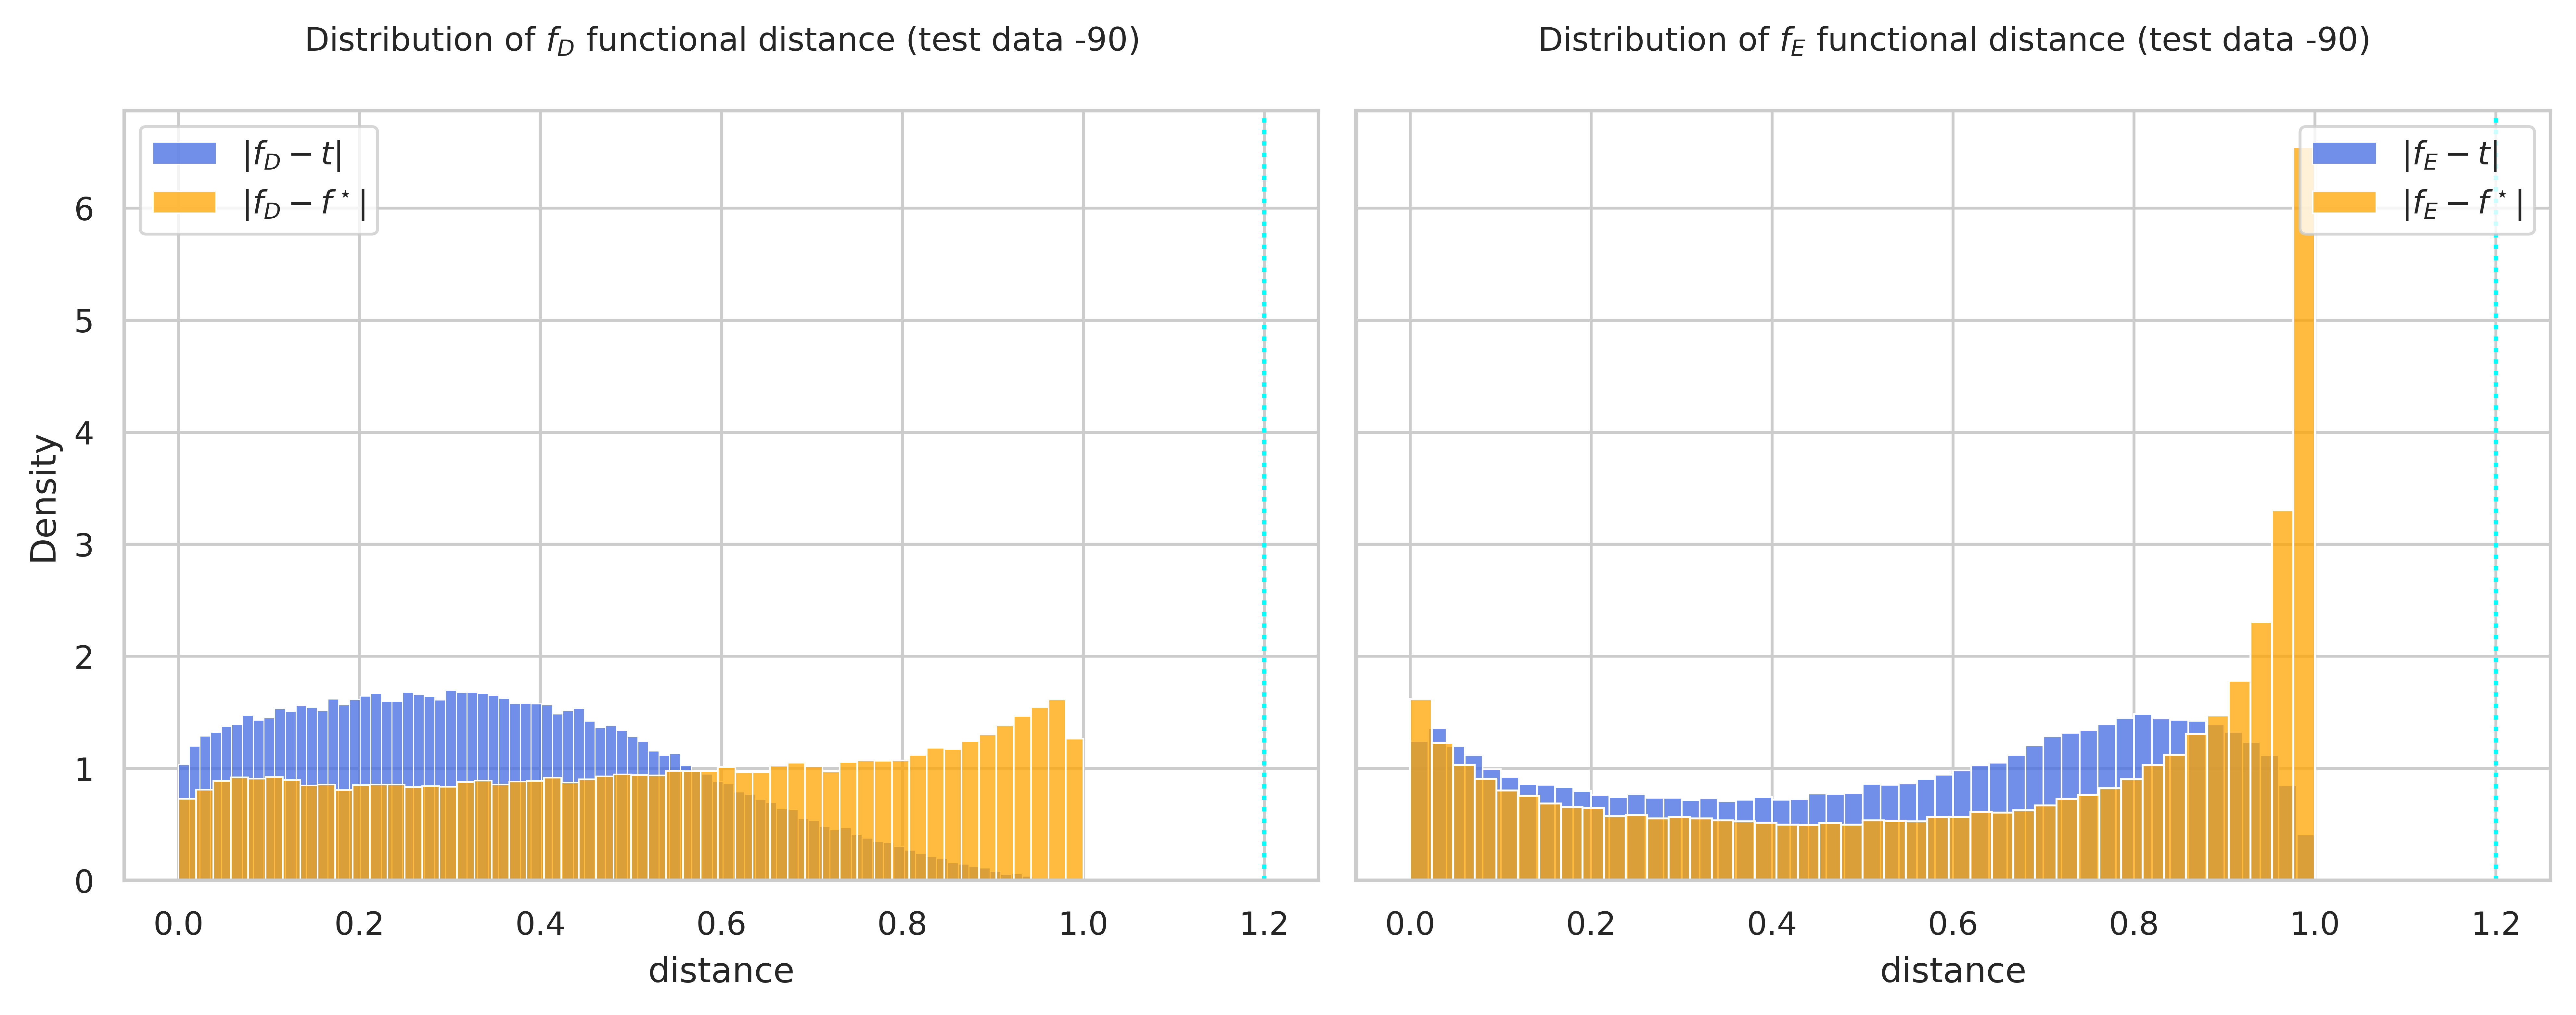

In [7]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    # first plot ---------------------------
    _df = res_df.loc[res_df['alpha']==0]
    _df = _df.loc[_df['buffer_size']==90000]


    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label="test", stat="density")

    ax[0].axvline(1.20, ls=':', color='aqua')


    ax[0].set_title(r"Distribution of $f_D$ functional distance (test data -90)", fontsize=9, y=1.05)
    

    # second plot ---------------------------
    _df = res_df.loc[res_df['alpha']==1]
    _df = _df.loc[_df['buffer_size']==90000]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label="test", stat="density")

    ax[1].axvline(1.20, ls=':', color='aqua')
    ax[1].set_title(r"Distribution of $f_E$ functional distance (test data -90)", fontsize=9, y=1.05)
    

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")
    ax[1].legend(h, [r'$|f_E - t|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


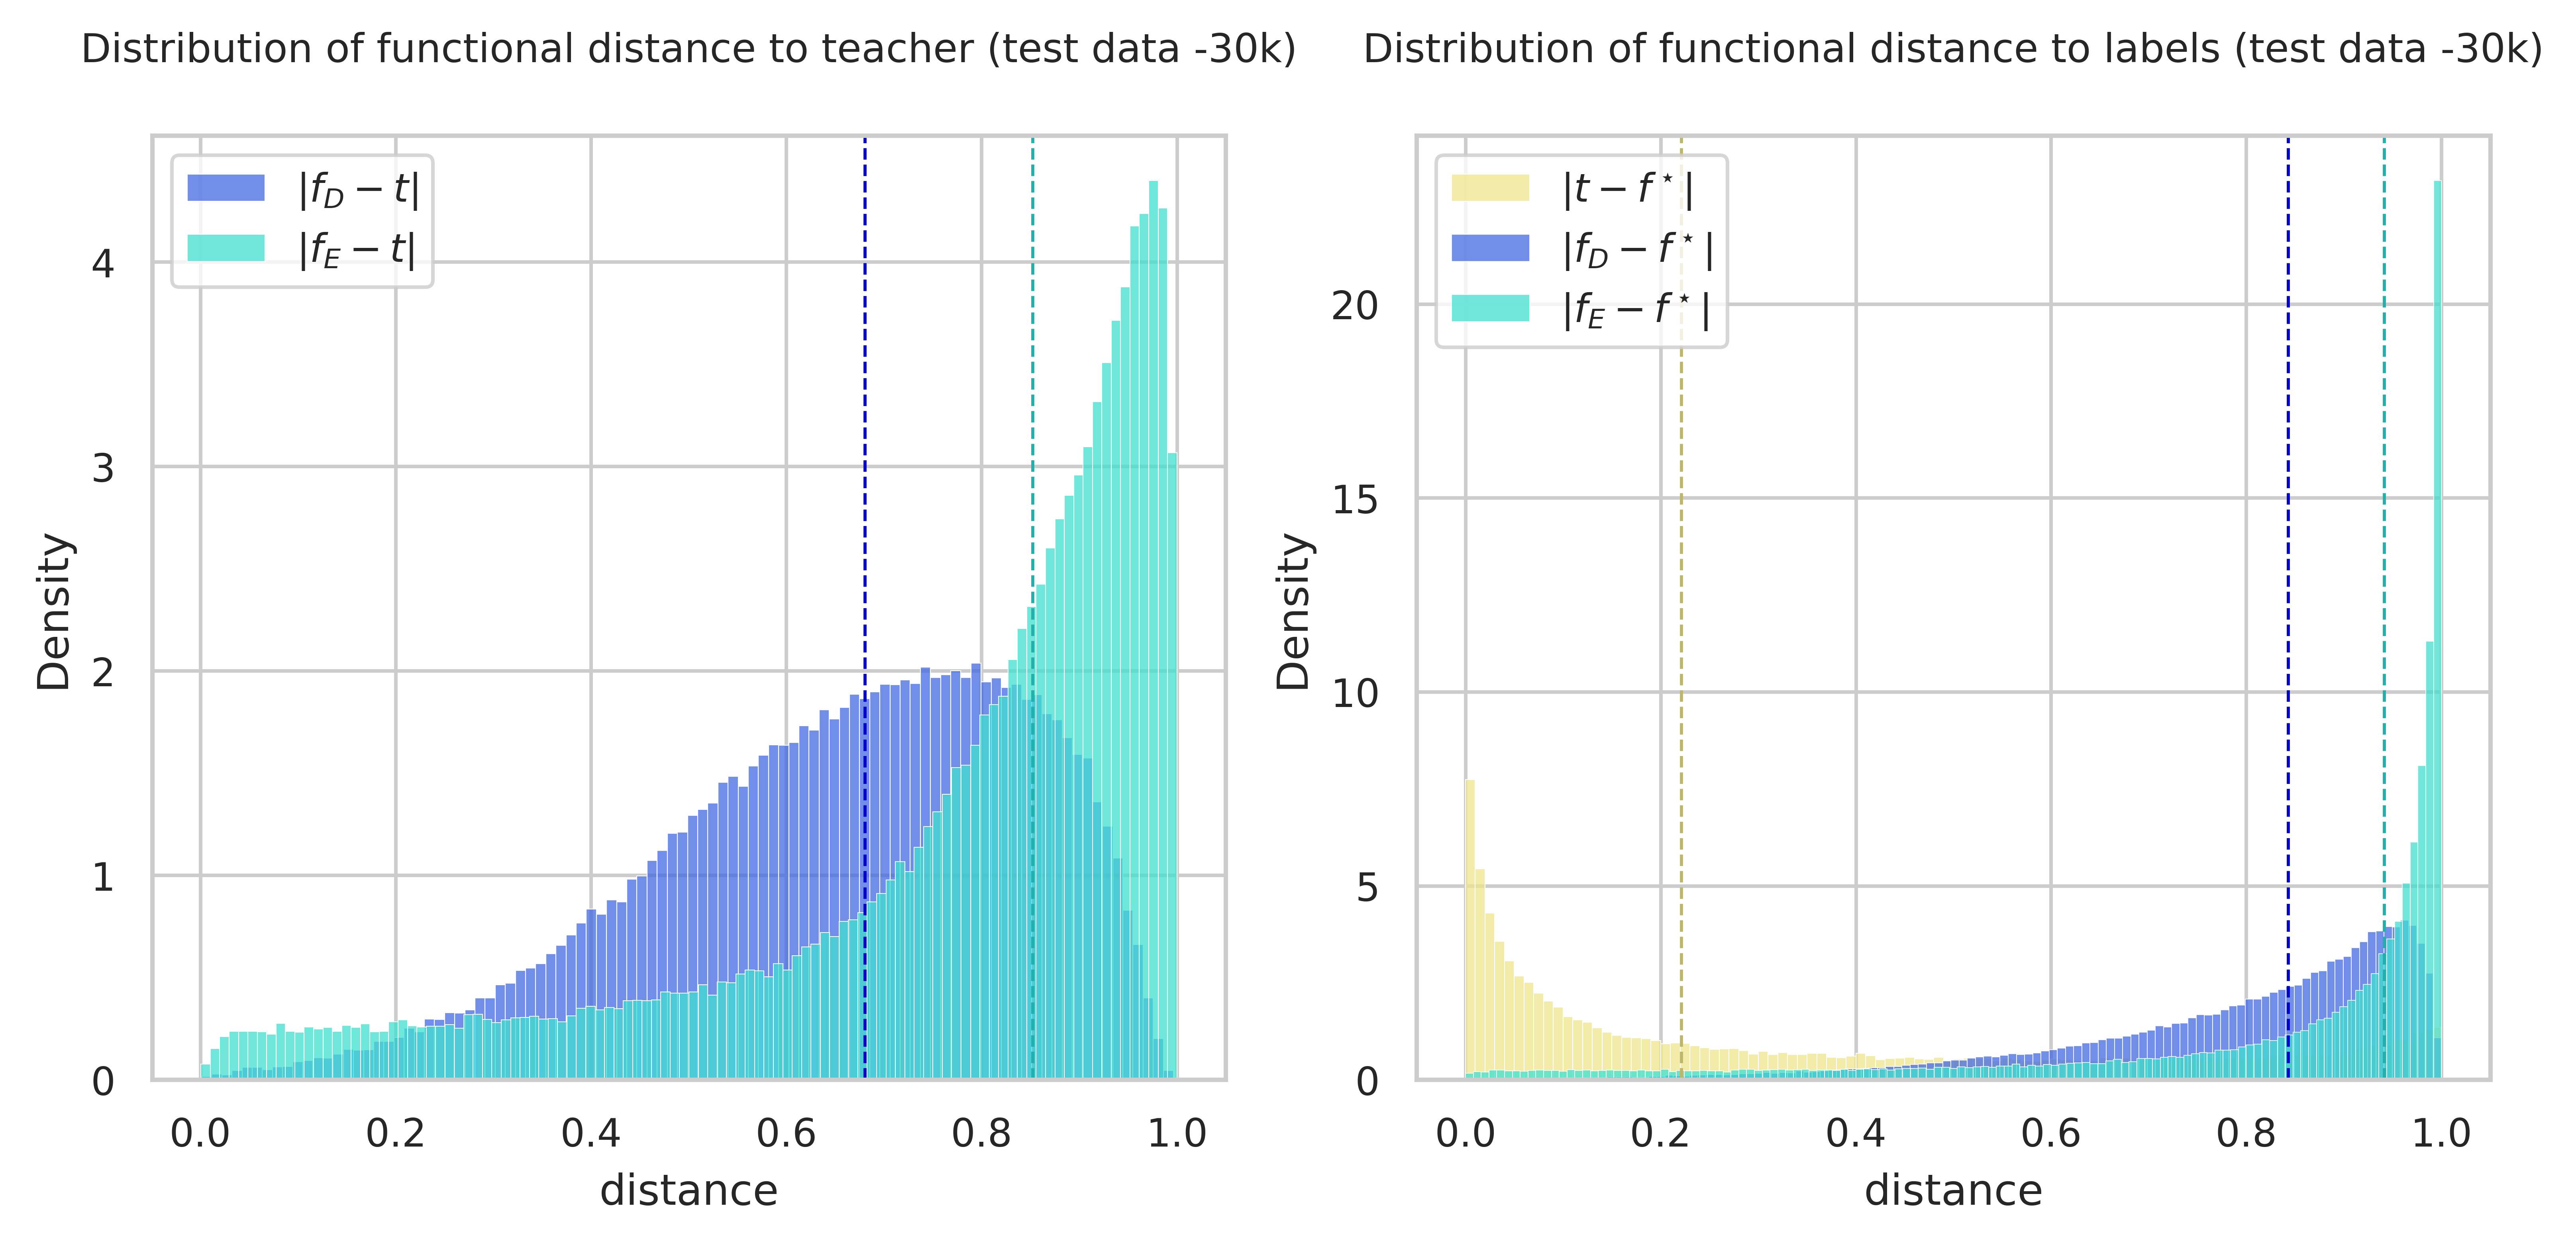

In [58]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data -30k)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==30000]


    sns.histplot(teacher_df_test, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    ax[1].axvline(teacher_df_test['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (test data -30k)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|t - f^\star|$',r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


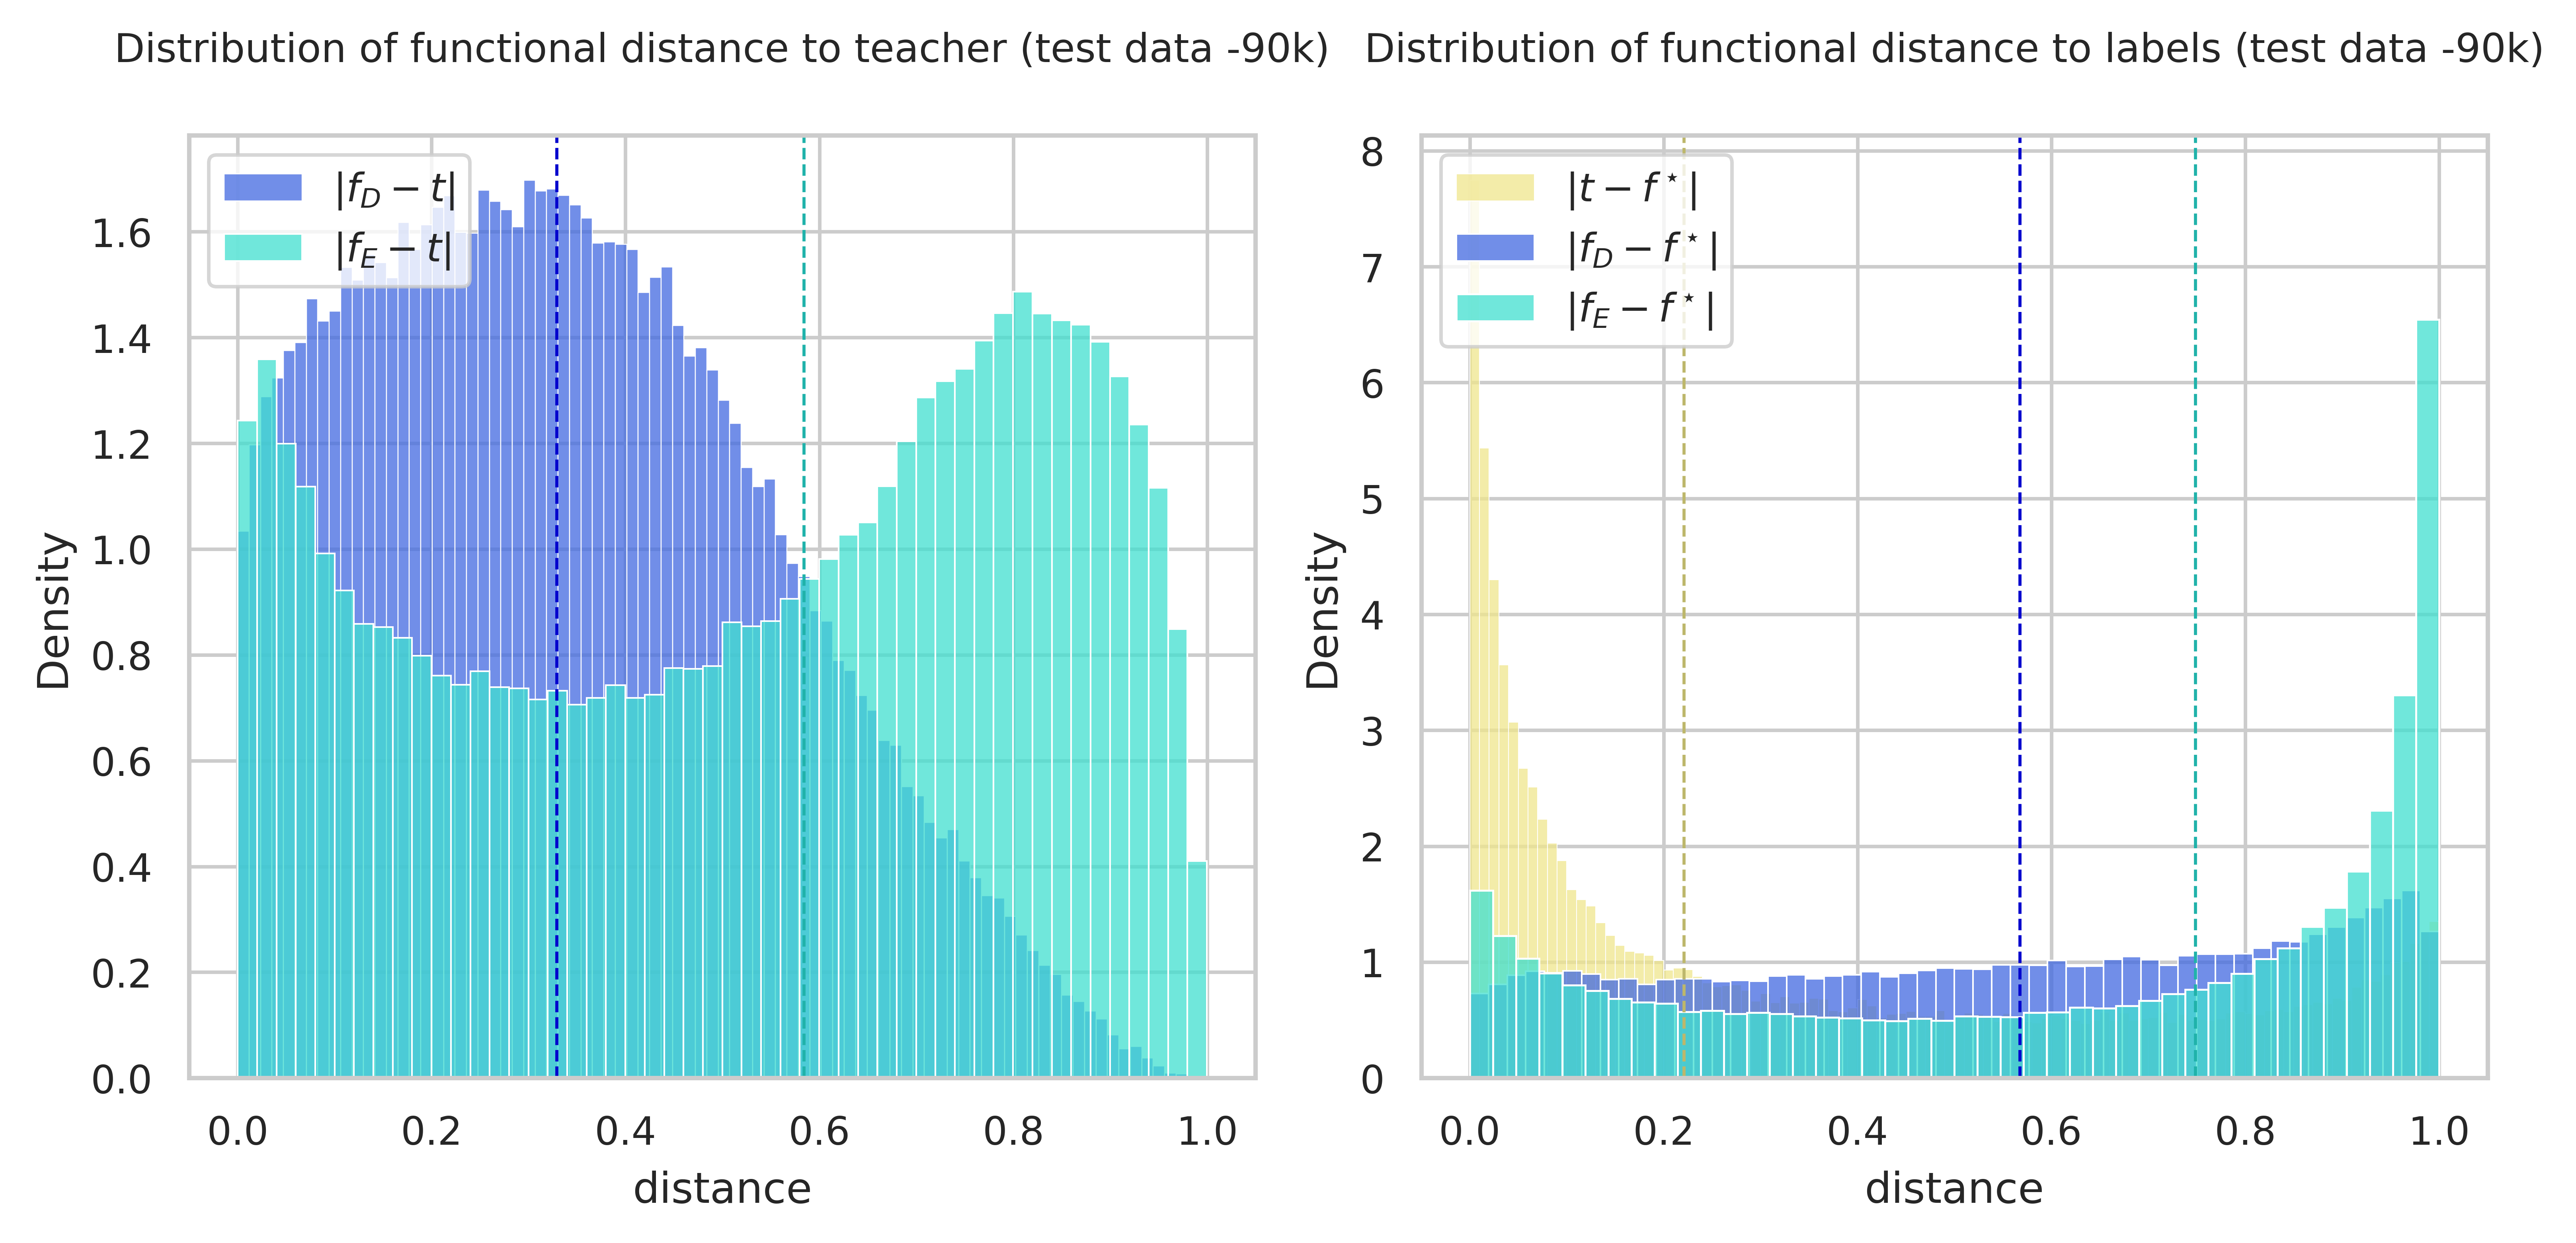

In [59]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==90000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data -90k)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==90000]


    sns.histplot(teacher_df_test, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    ax[1].axvline(teacher_df_test['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (test data -90k)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|t - f^\star|$',r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


## Train data imagenet

In [60]:
logs_path = './logs/results/imagenet/resnet50/FDIST.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

alpha  batch  buffer_size  seed   test  teacher  distance
0          1.0      0        30000    11  False     True  0.970781
1          1.0      0        30000    11  False    False  0.981675
2          1.0      0        30000    11  False     True  0.662954
3          1.0      0        30000    11  False    False  0.887247
4          1.0      0        30000    11  False     True  0.907670
...        ...    ...          ...   ...    ...      ...       ...
4799995    0.0   1562        90000    21  False    False  0.915391
4799996    0.0   1562        90000    21  False     True  0.352295
4799997    0.0   1562        90000    21  False    False  0.422148
4799998    0.0   1562        90000    21  False     True  0.267705
4799999    0.0   1562        90000    21  False    False  0.611940

[4800000 rows x 7 columns]

In [23]:
res_df.loc[res_df['buffer_size']==90000].loc[res_df['seed']==55]['alpha'].unique()

array([], dtype=float64)

In [11]:
res_df['buffer_size'].unique()

array([30000, 90000])

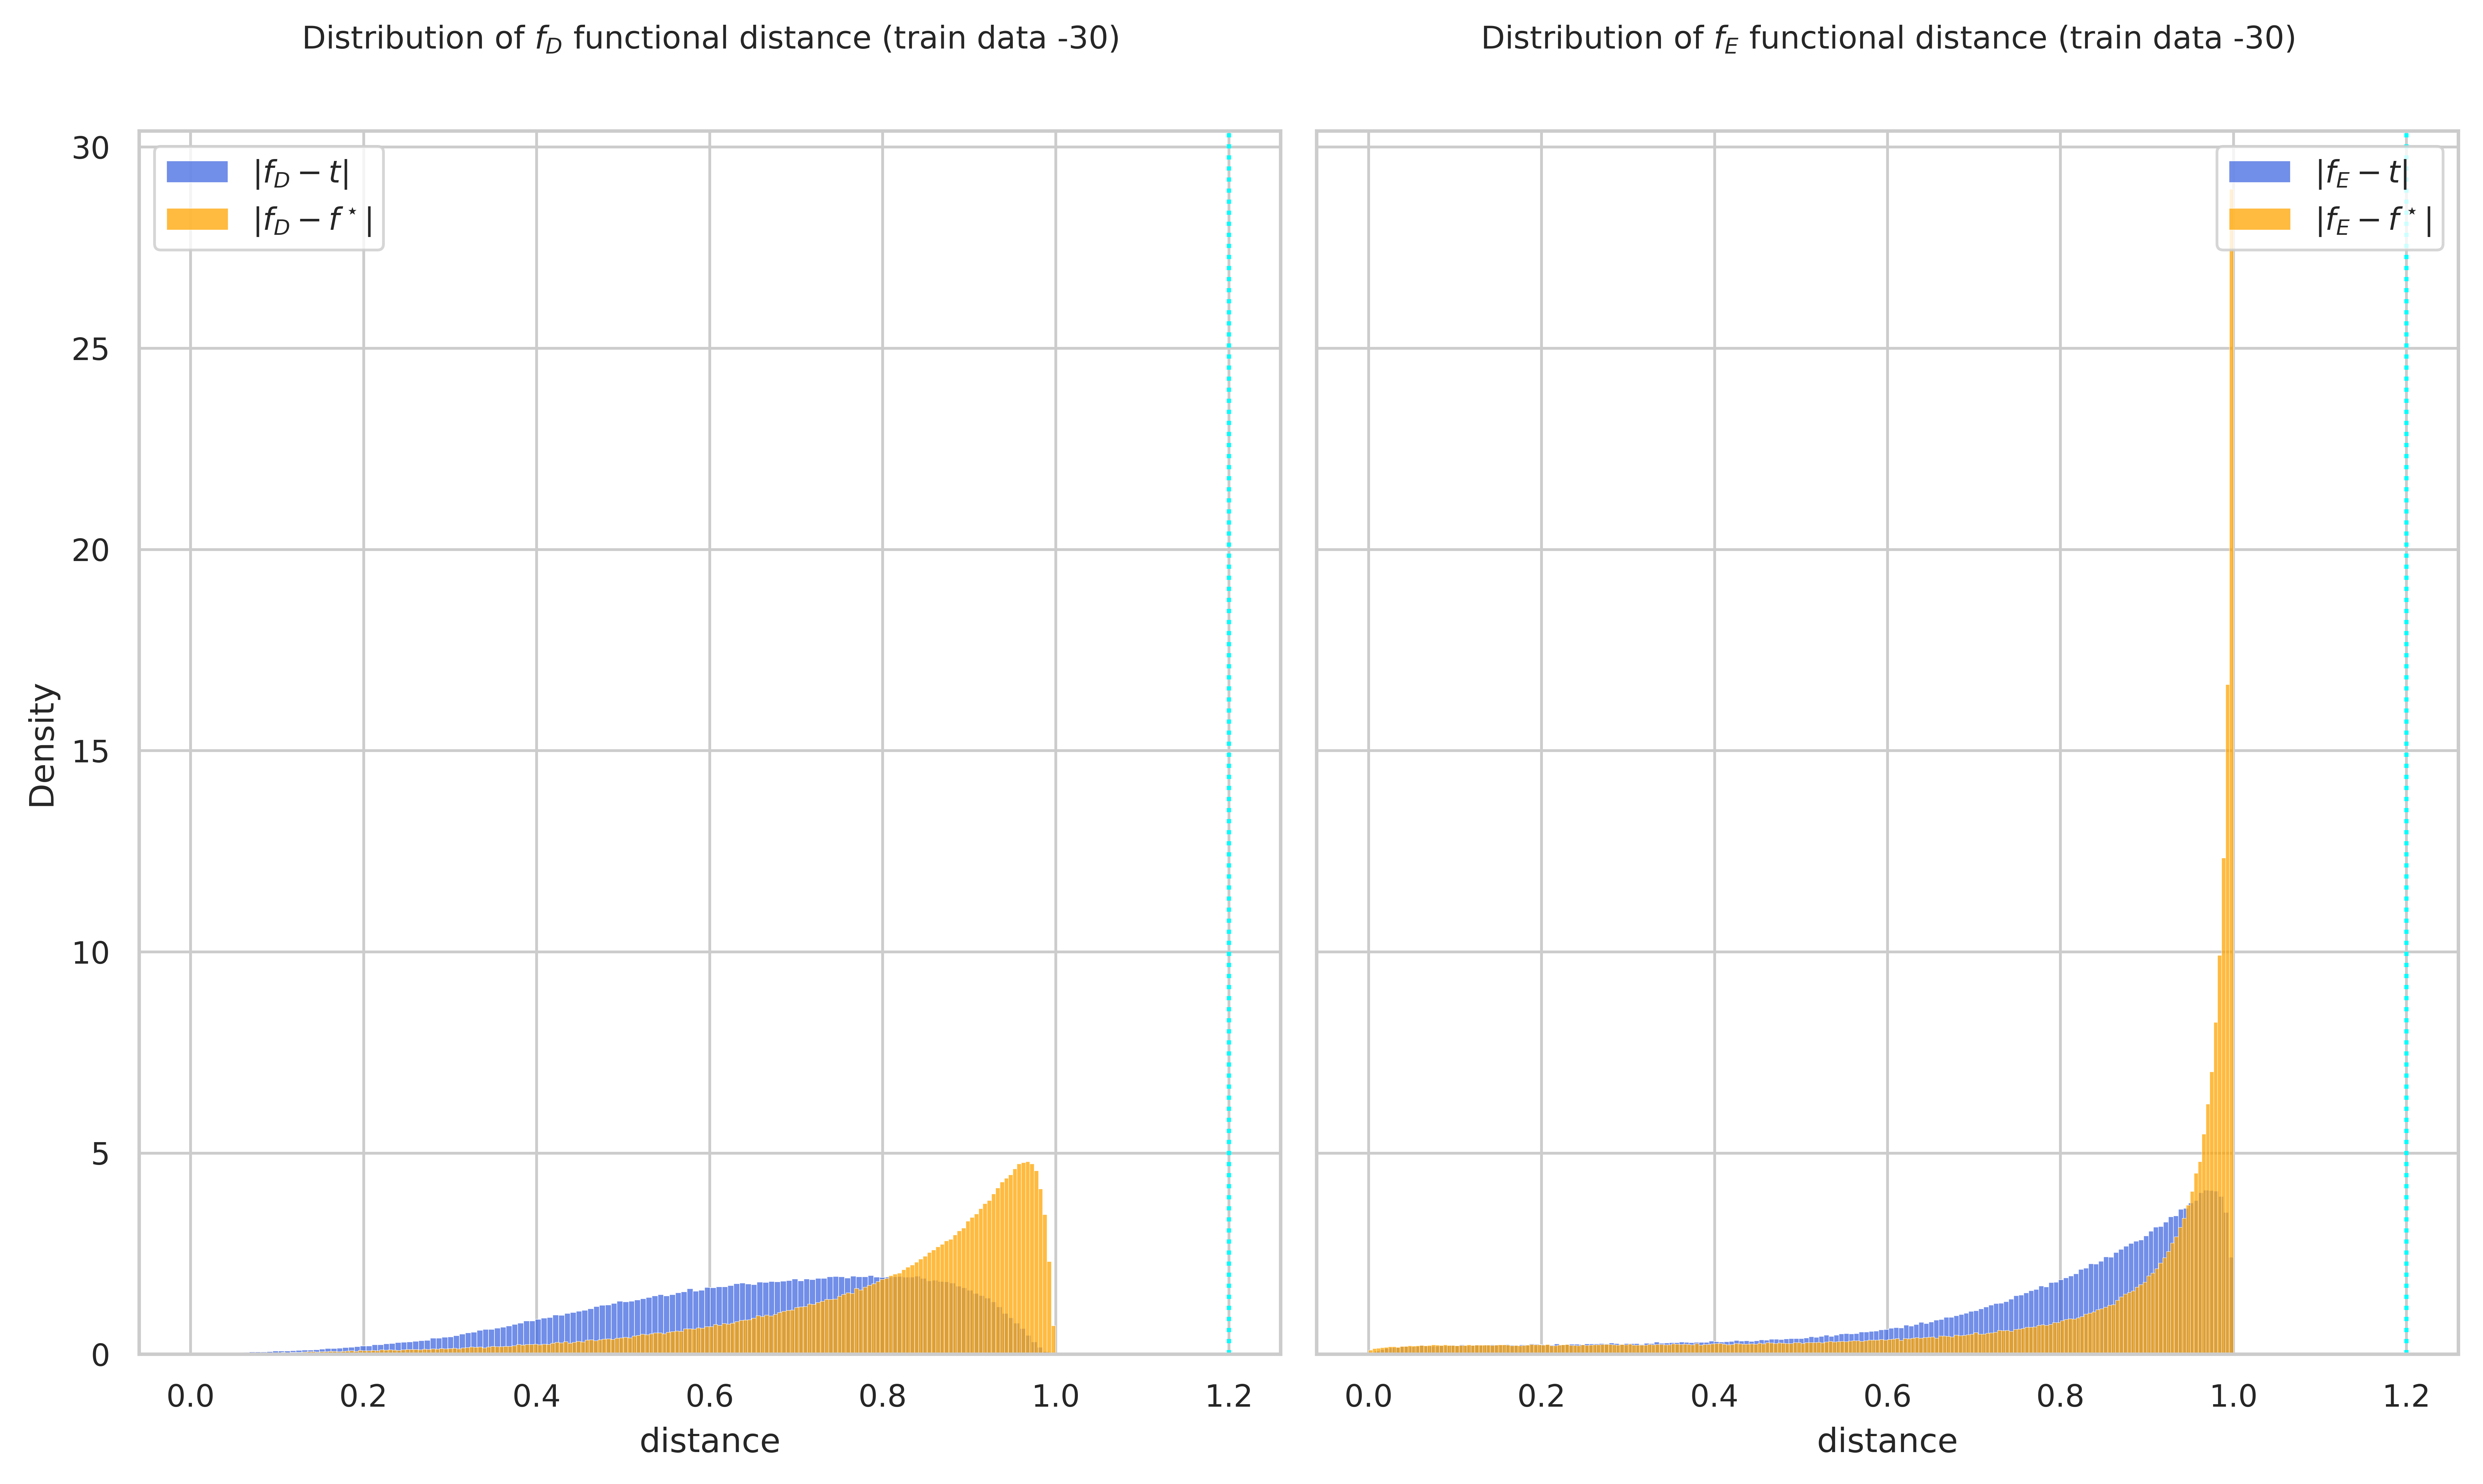

In [22]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    # first plot ---------------------------
    _df = res_df.loc[res_df['alpha']==0]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label="test", stat="density")

    ax[0].axvline(1.20, ls=':', color='aqua')


    ax[0].set_title(r"Distribution of $f_D$ functional distance (train data -30)", fontsize=9, y=1.05)
    

    # second plot ---------------------------
    _df = res_df.loc[res_df['alpha']==1]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label="test", stat="density")

    ax[1].axvline(1.20, ls=':', color='aqua')
    ax[1].set_title(r"Distribution of $f_E$ functional distance (train data -30)", fontsize=9, y=1.05)
    

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")
    ax[1].legend(h, [r'$|f_E - t|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


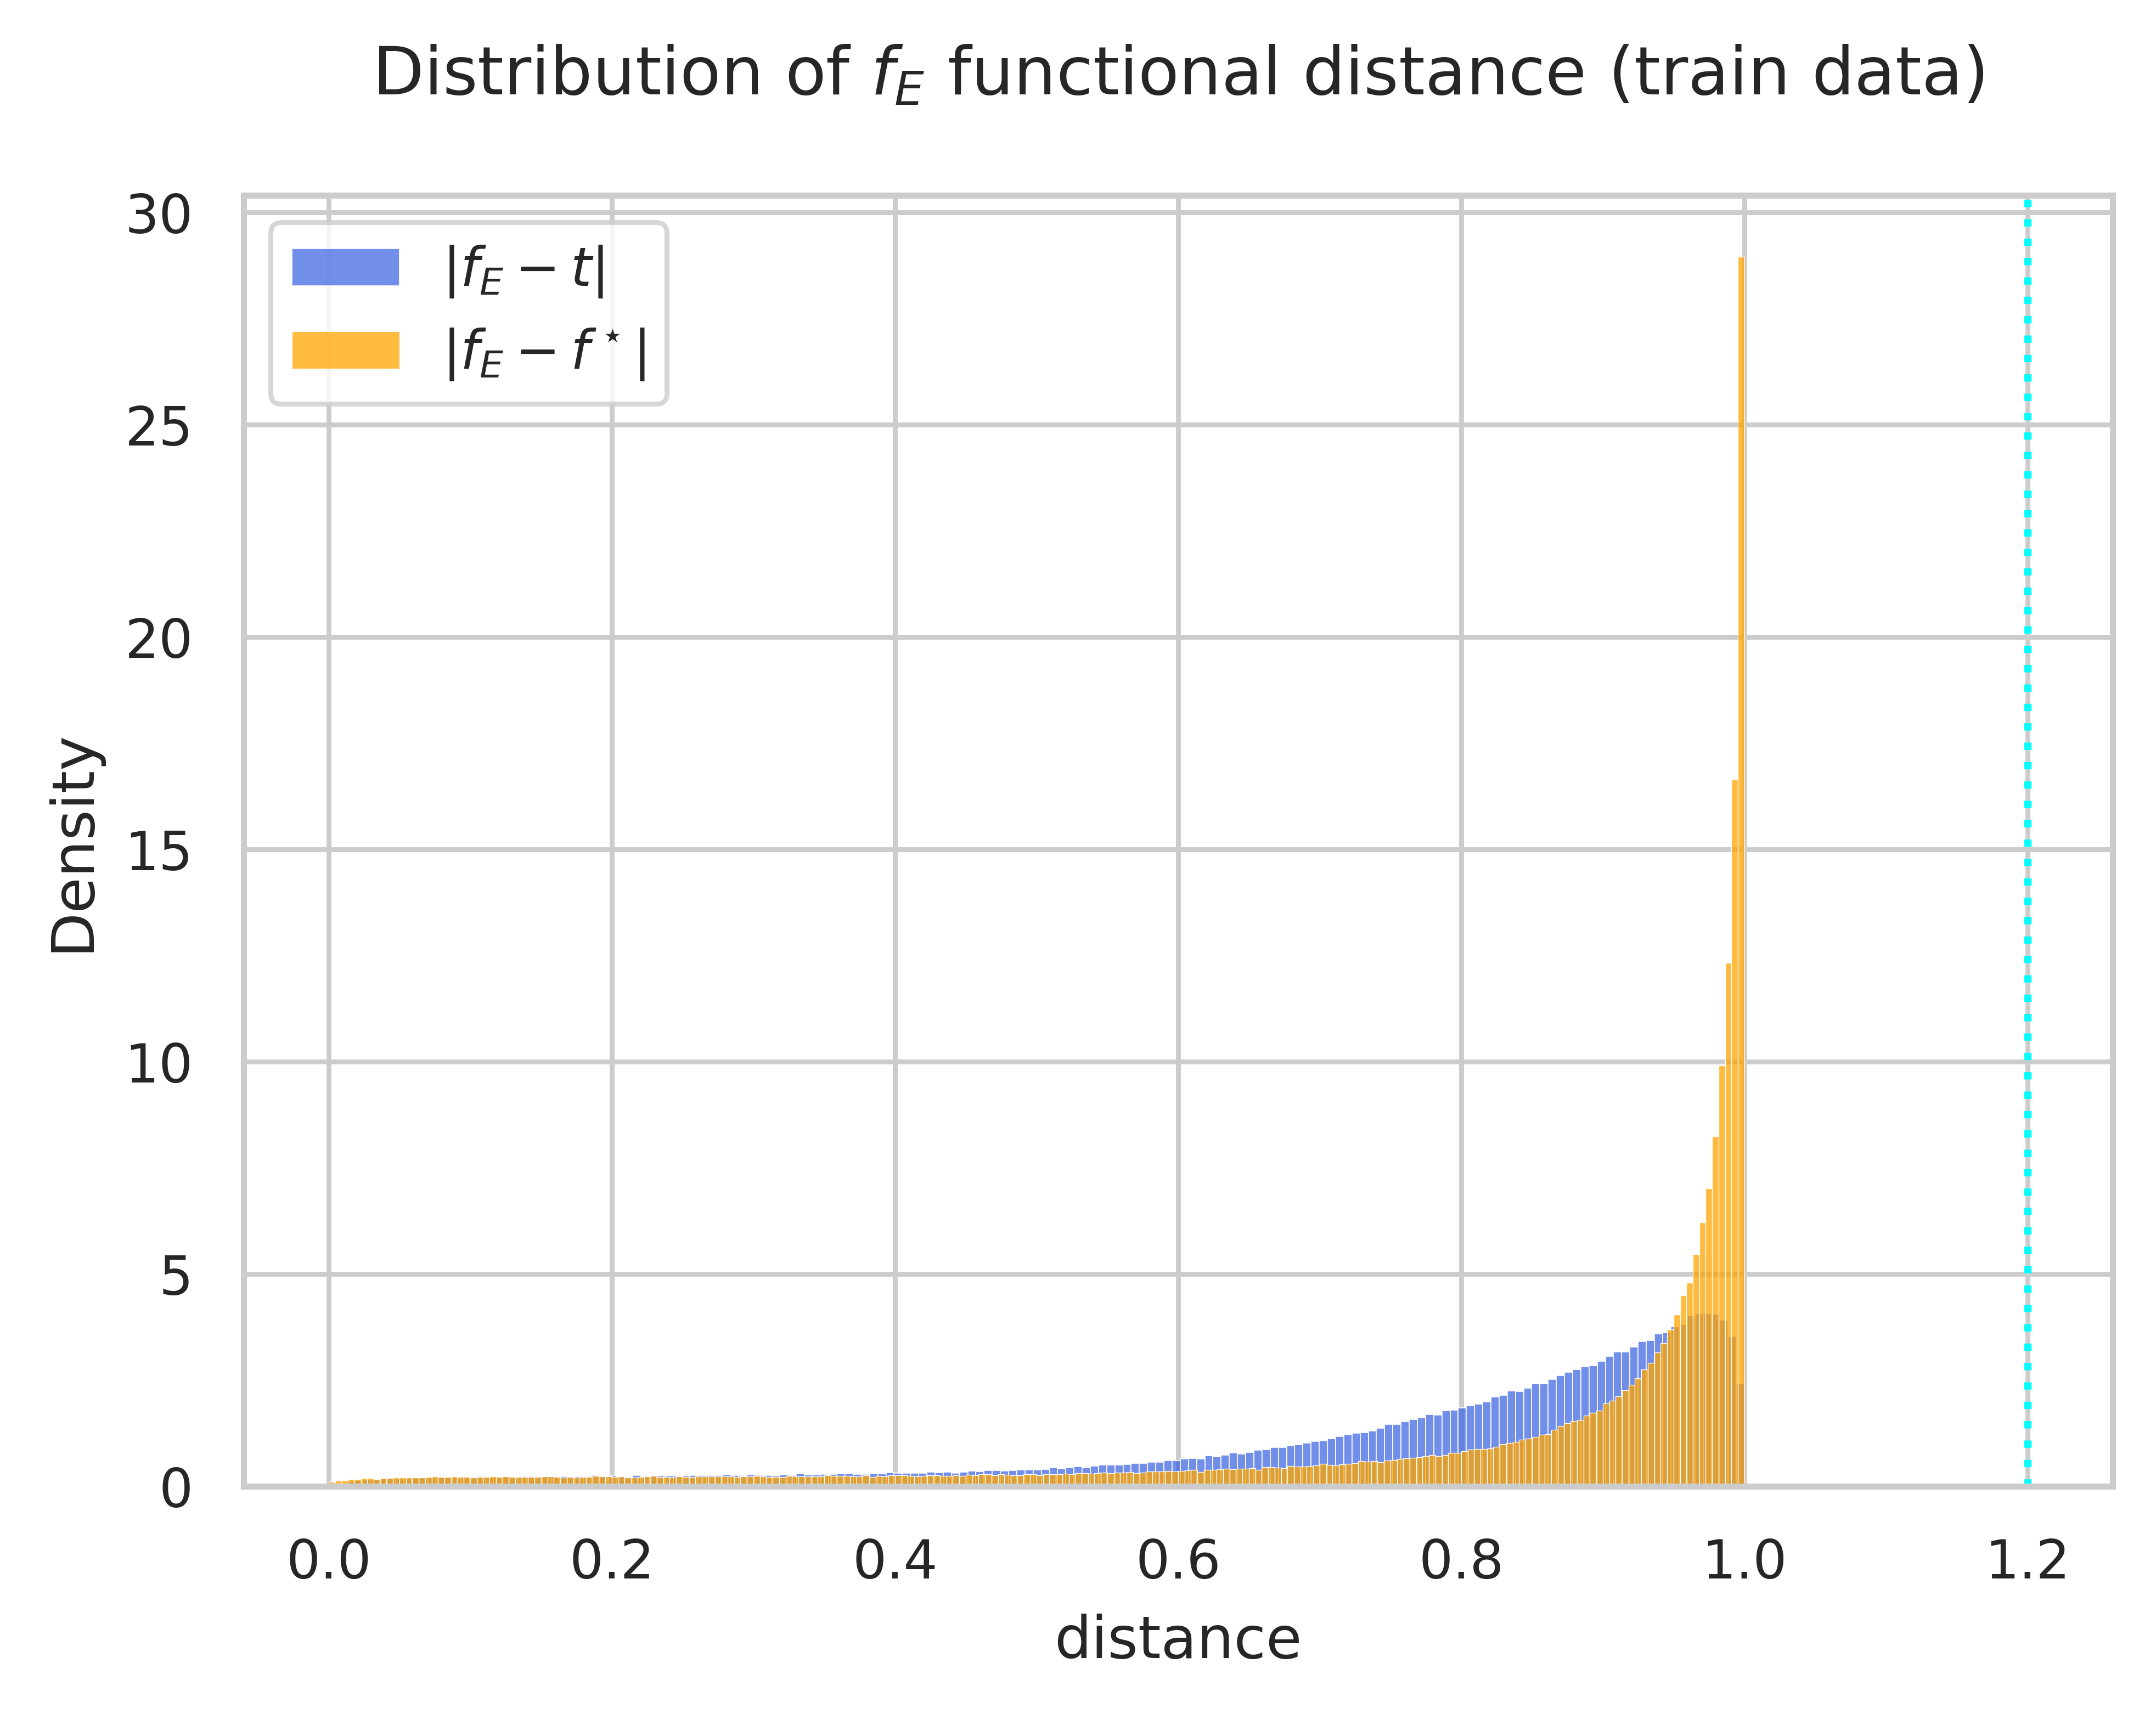

In [23]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    _df = res_df.loc[res_df['alpha']==1]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax, color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax, color=colors[1], label="test", stat="density")

    ax.set_title(r"Distribution of $f_E$ functional distance (train data)", fontsize=11, y=1.05)
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'$|f_E - t|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    ax.axvline(1.20, ls=':', color='aqua')

    
    plt.tight_layout()


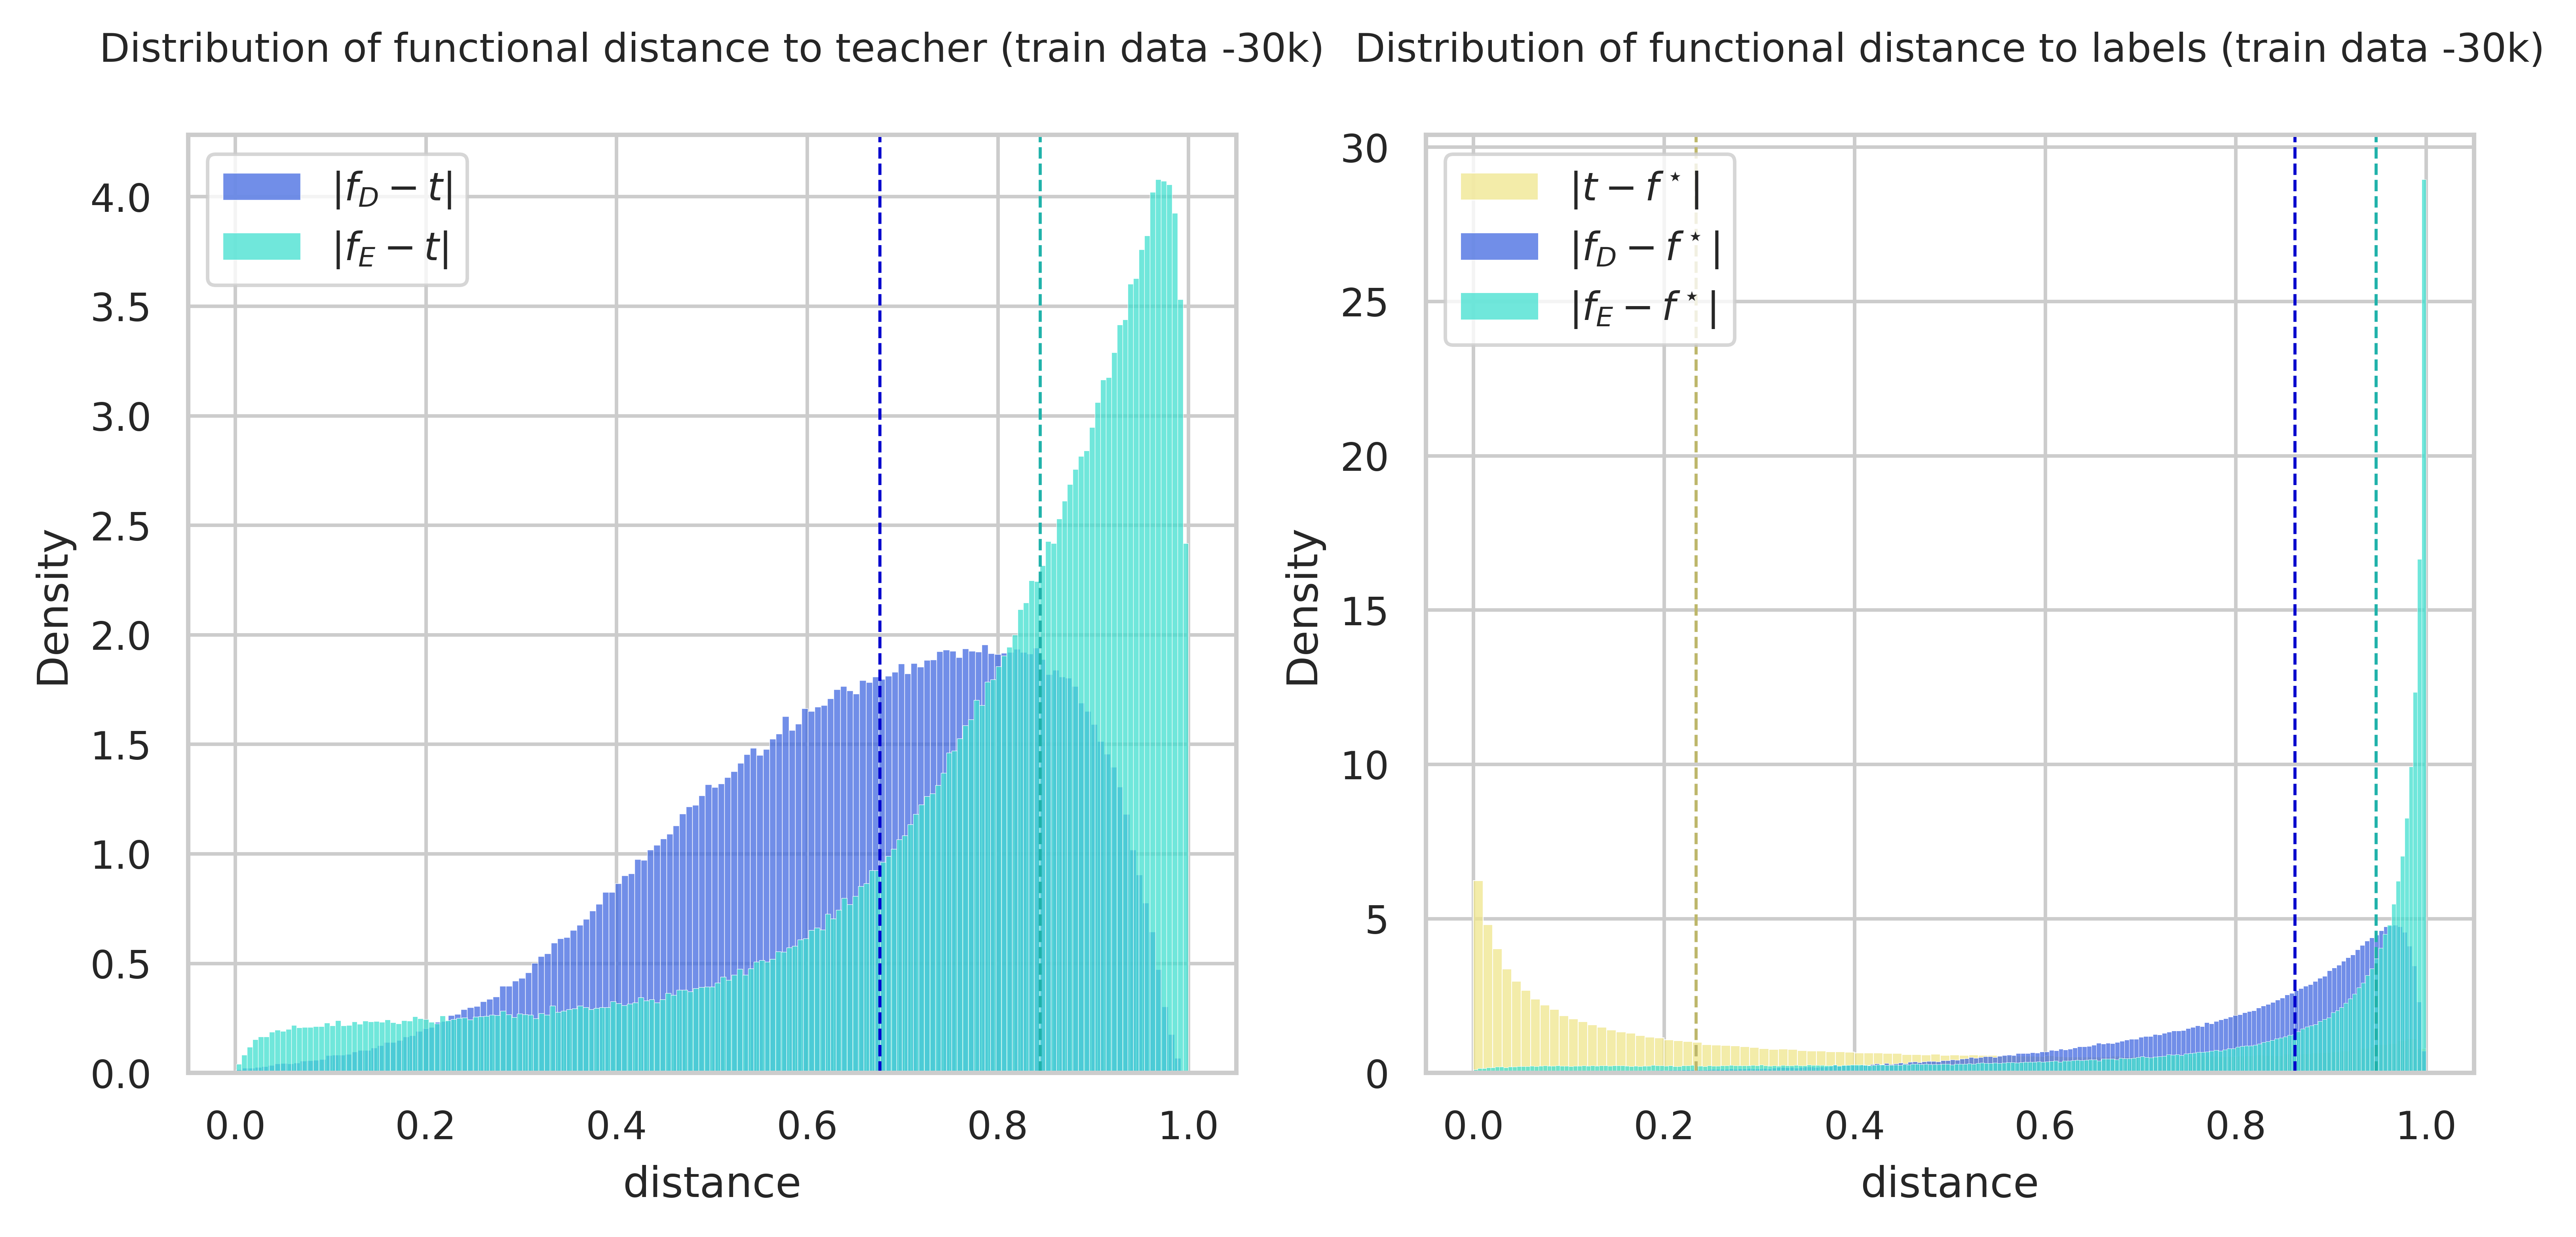

In [61]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==30000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (train data -30k)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==30000]


    sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data -30k)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|t - f^\star|$',r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


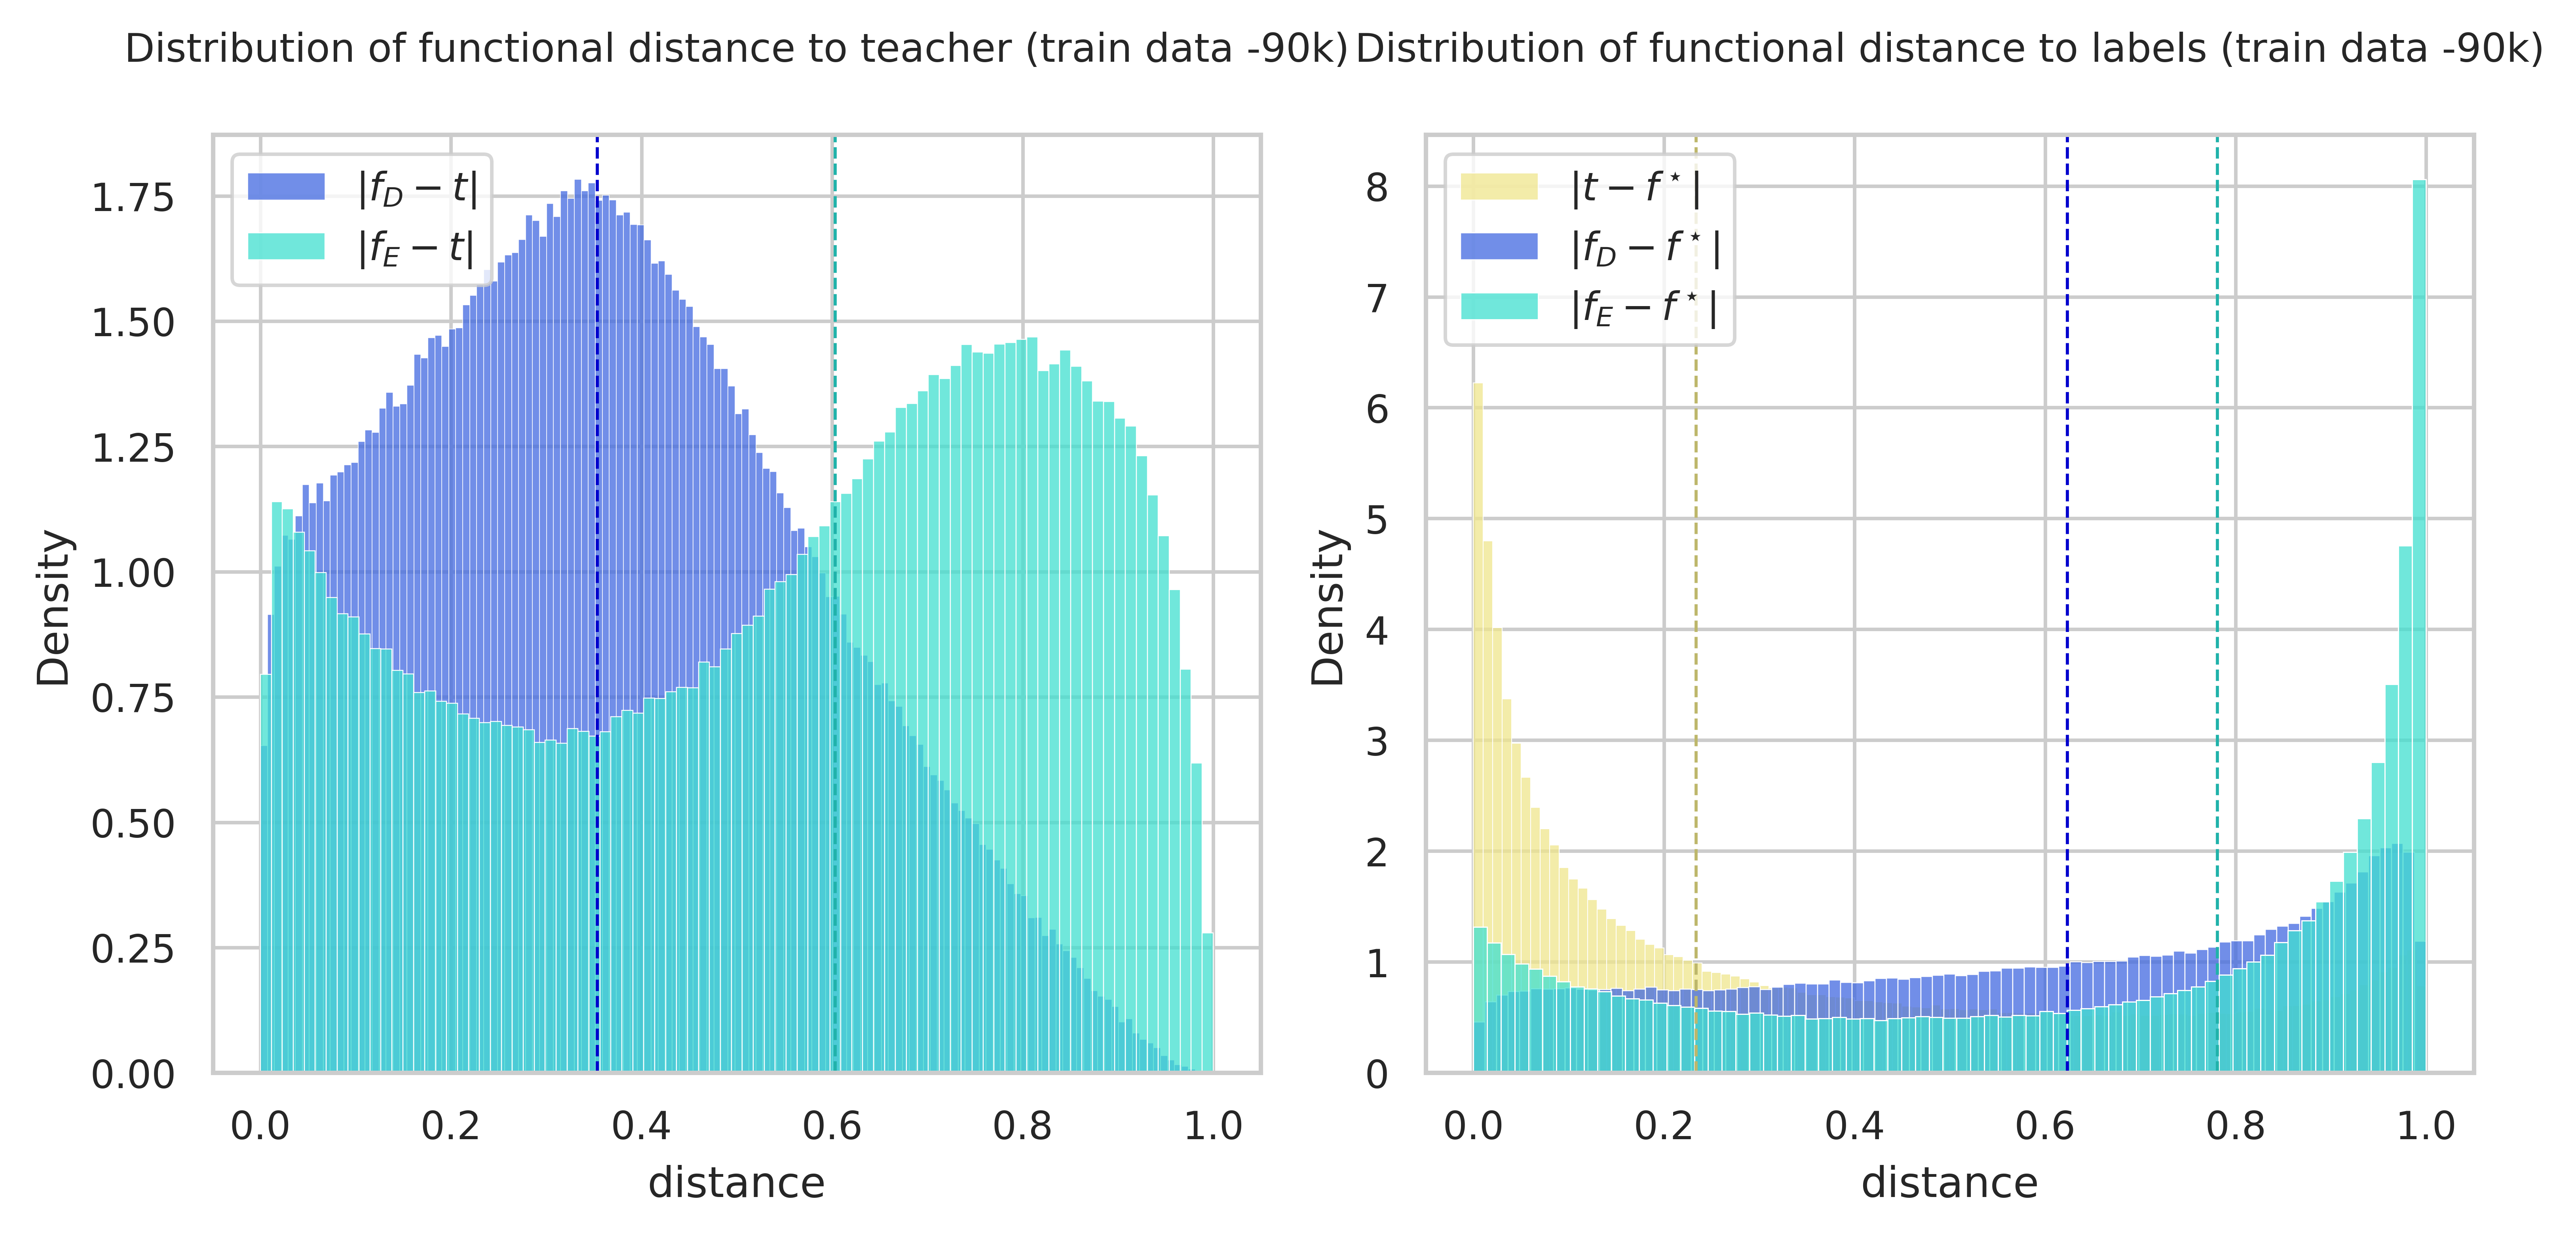

In [62]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==90000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (train data -90k)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==90000]


    sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data -90k)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|t - f^\star|$',r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


# Test data cifar10

In [4]:
logs_path = './logs/results/cifar5m/mnet/FDIST_cifar10_test.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

alpha  batch  buffer_size  seed  test  teacher  distance
0         1.0      0       600000    11  True     True  0.048461
1         1.0      0       600000    11  True    False  0.025478
2         1.0      0       600000    11  True     True  0.213646
3         1.0      0       600000    11  True    False  0.696702
4         1.0      0       600000    11  True     True  0.070589
...       ...    ...          ...   ...   ...      ...       ...
599995    0.0     78        60000    55  True    False  0.072001
599996    0.0     78        60000    55  True     True  0.371444
599997    0.0     78        60000    55  True    False  0.850250
599998    0.0     78        60000    55  True     True  0.010002
599999    0.0     78        60000    55  True    False  0.005457

[600000 rows x 7 columns]

In [5]:
res_df['buffer_size'].unique()

array([600000, 120000,  60000])

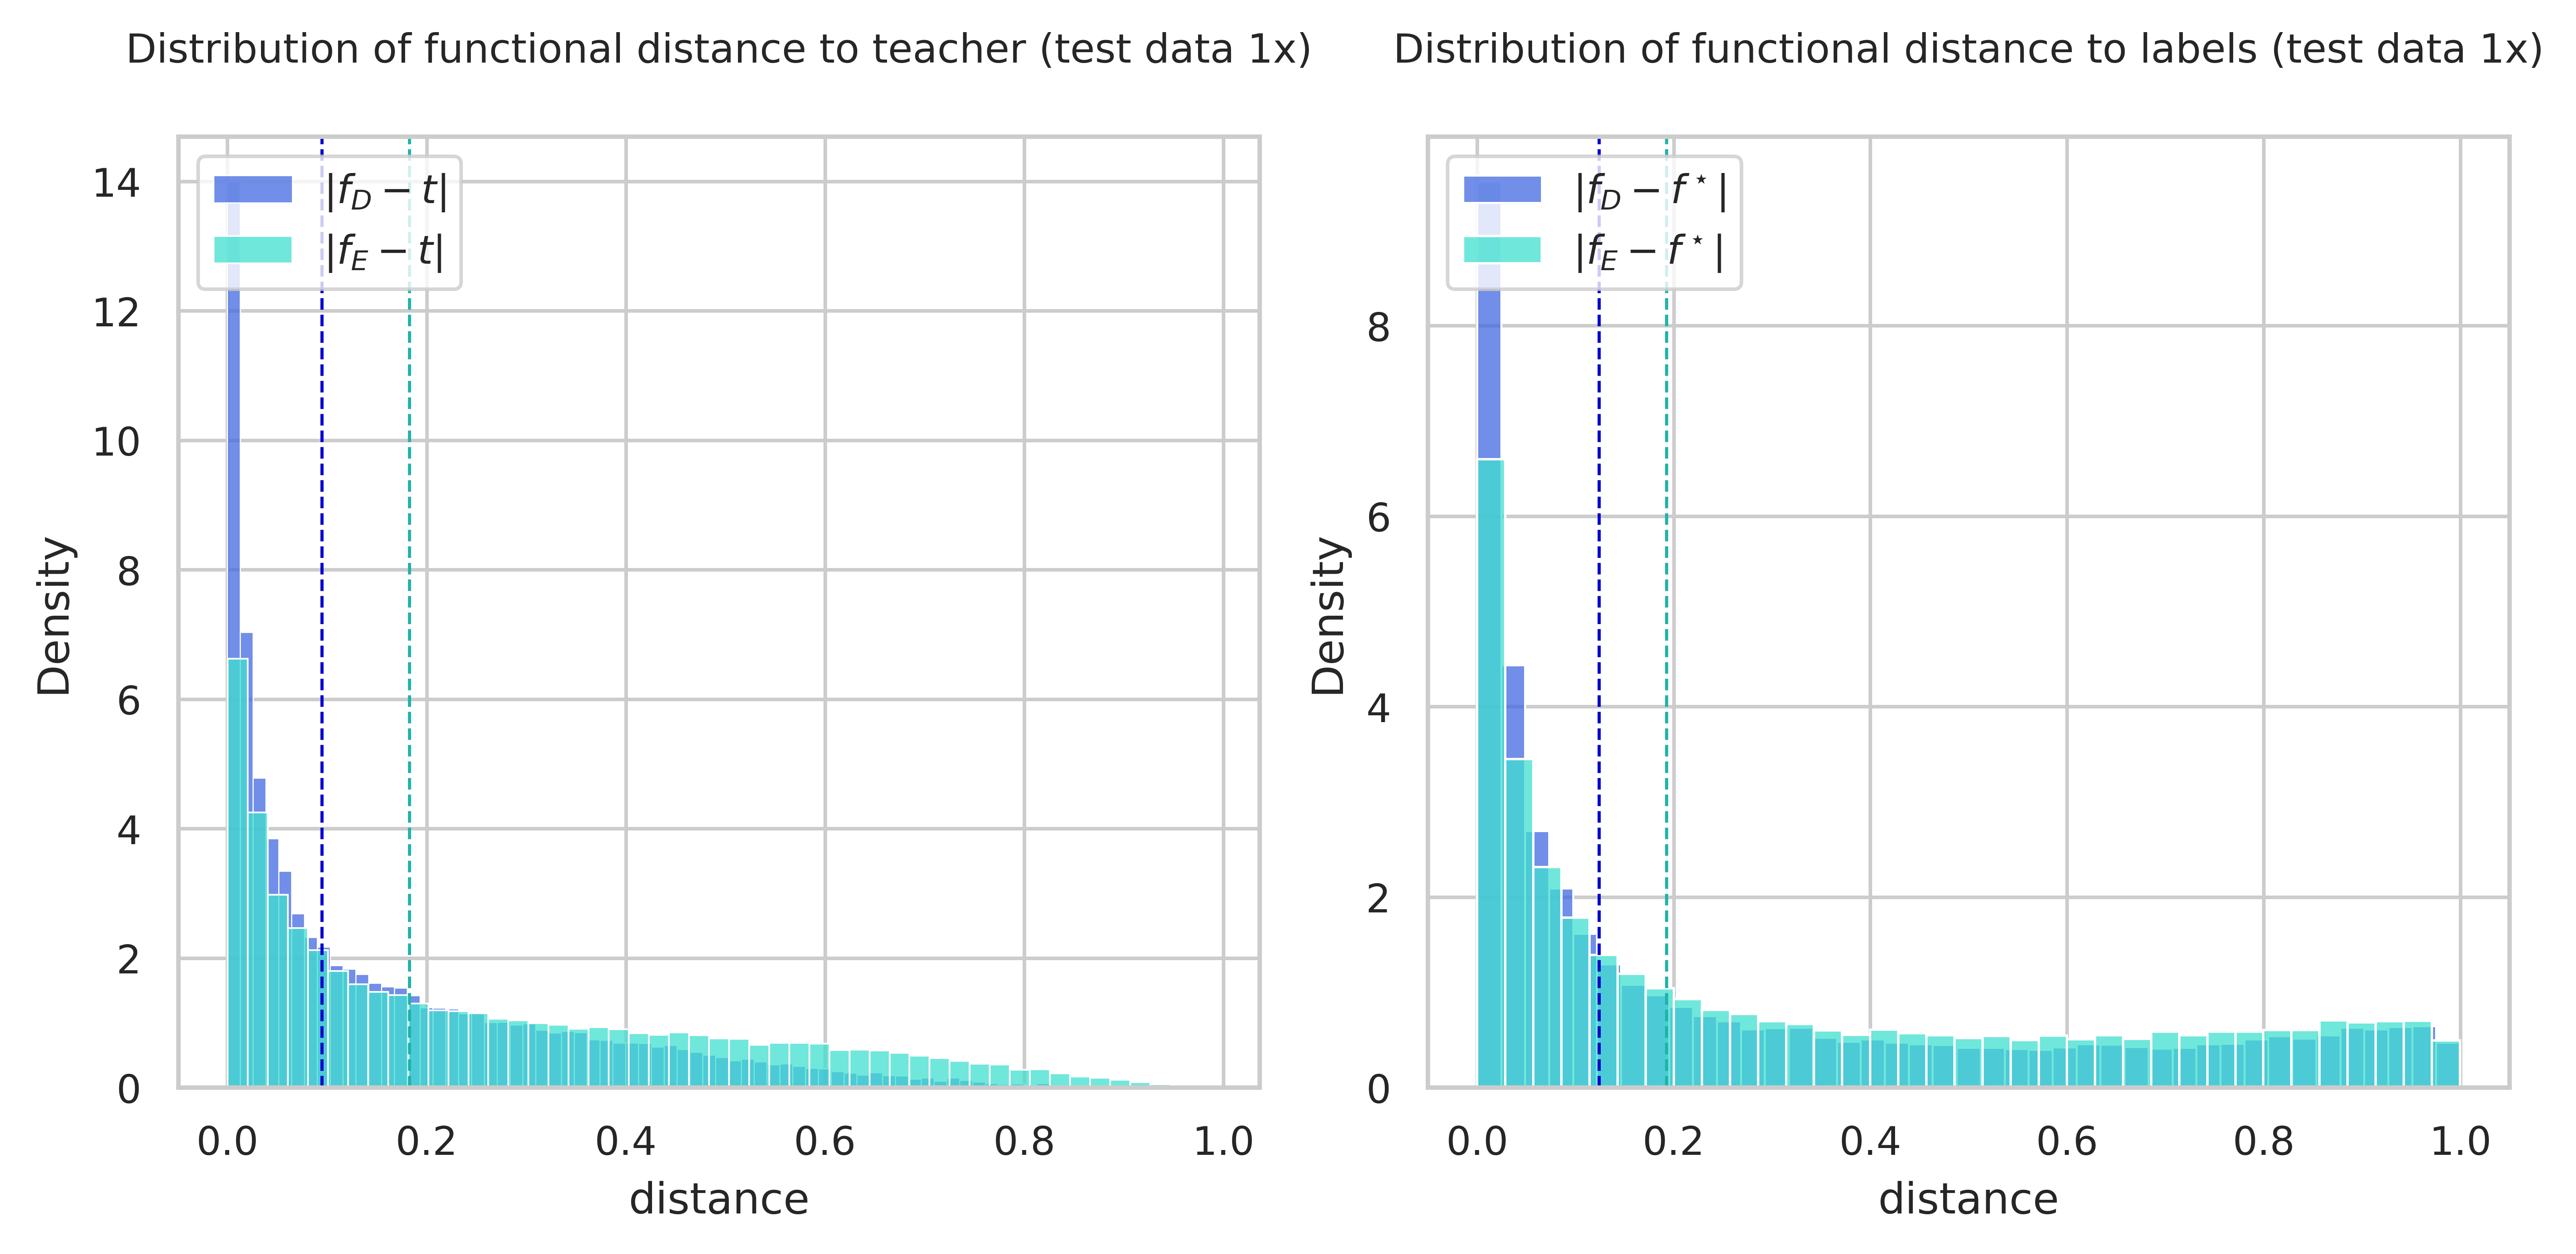

In [9]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==60000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data 1x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==60000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (test data 1x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


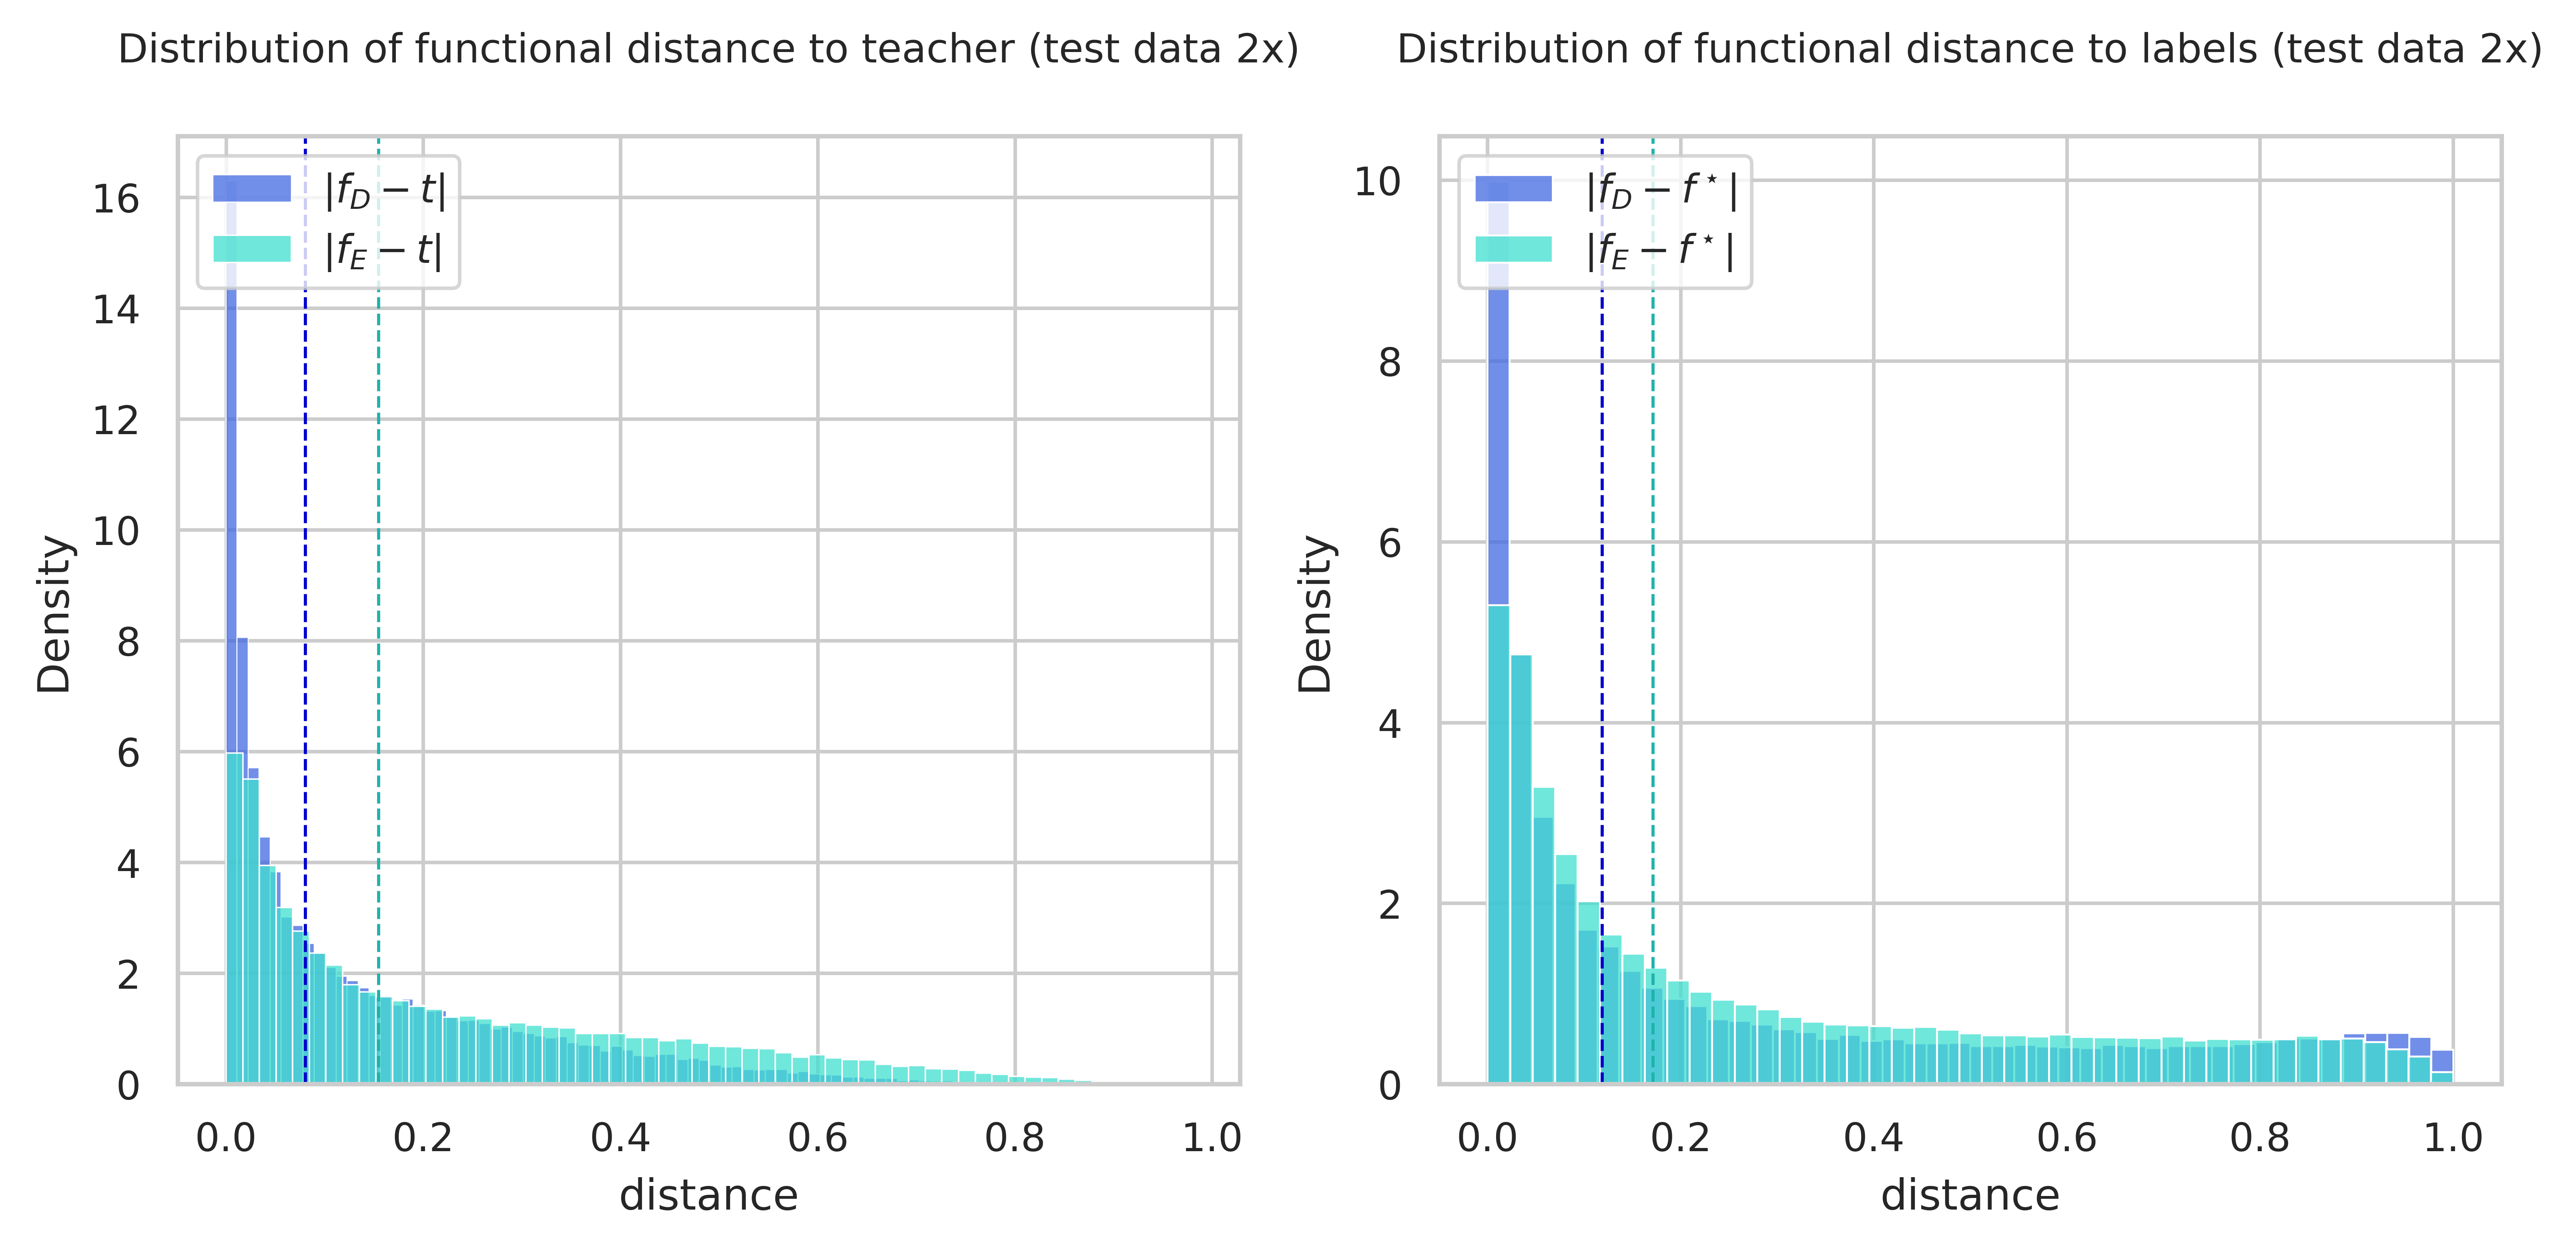

In [10]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==120000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data 2x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==120000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (test data 2x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


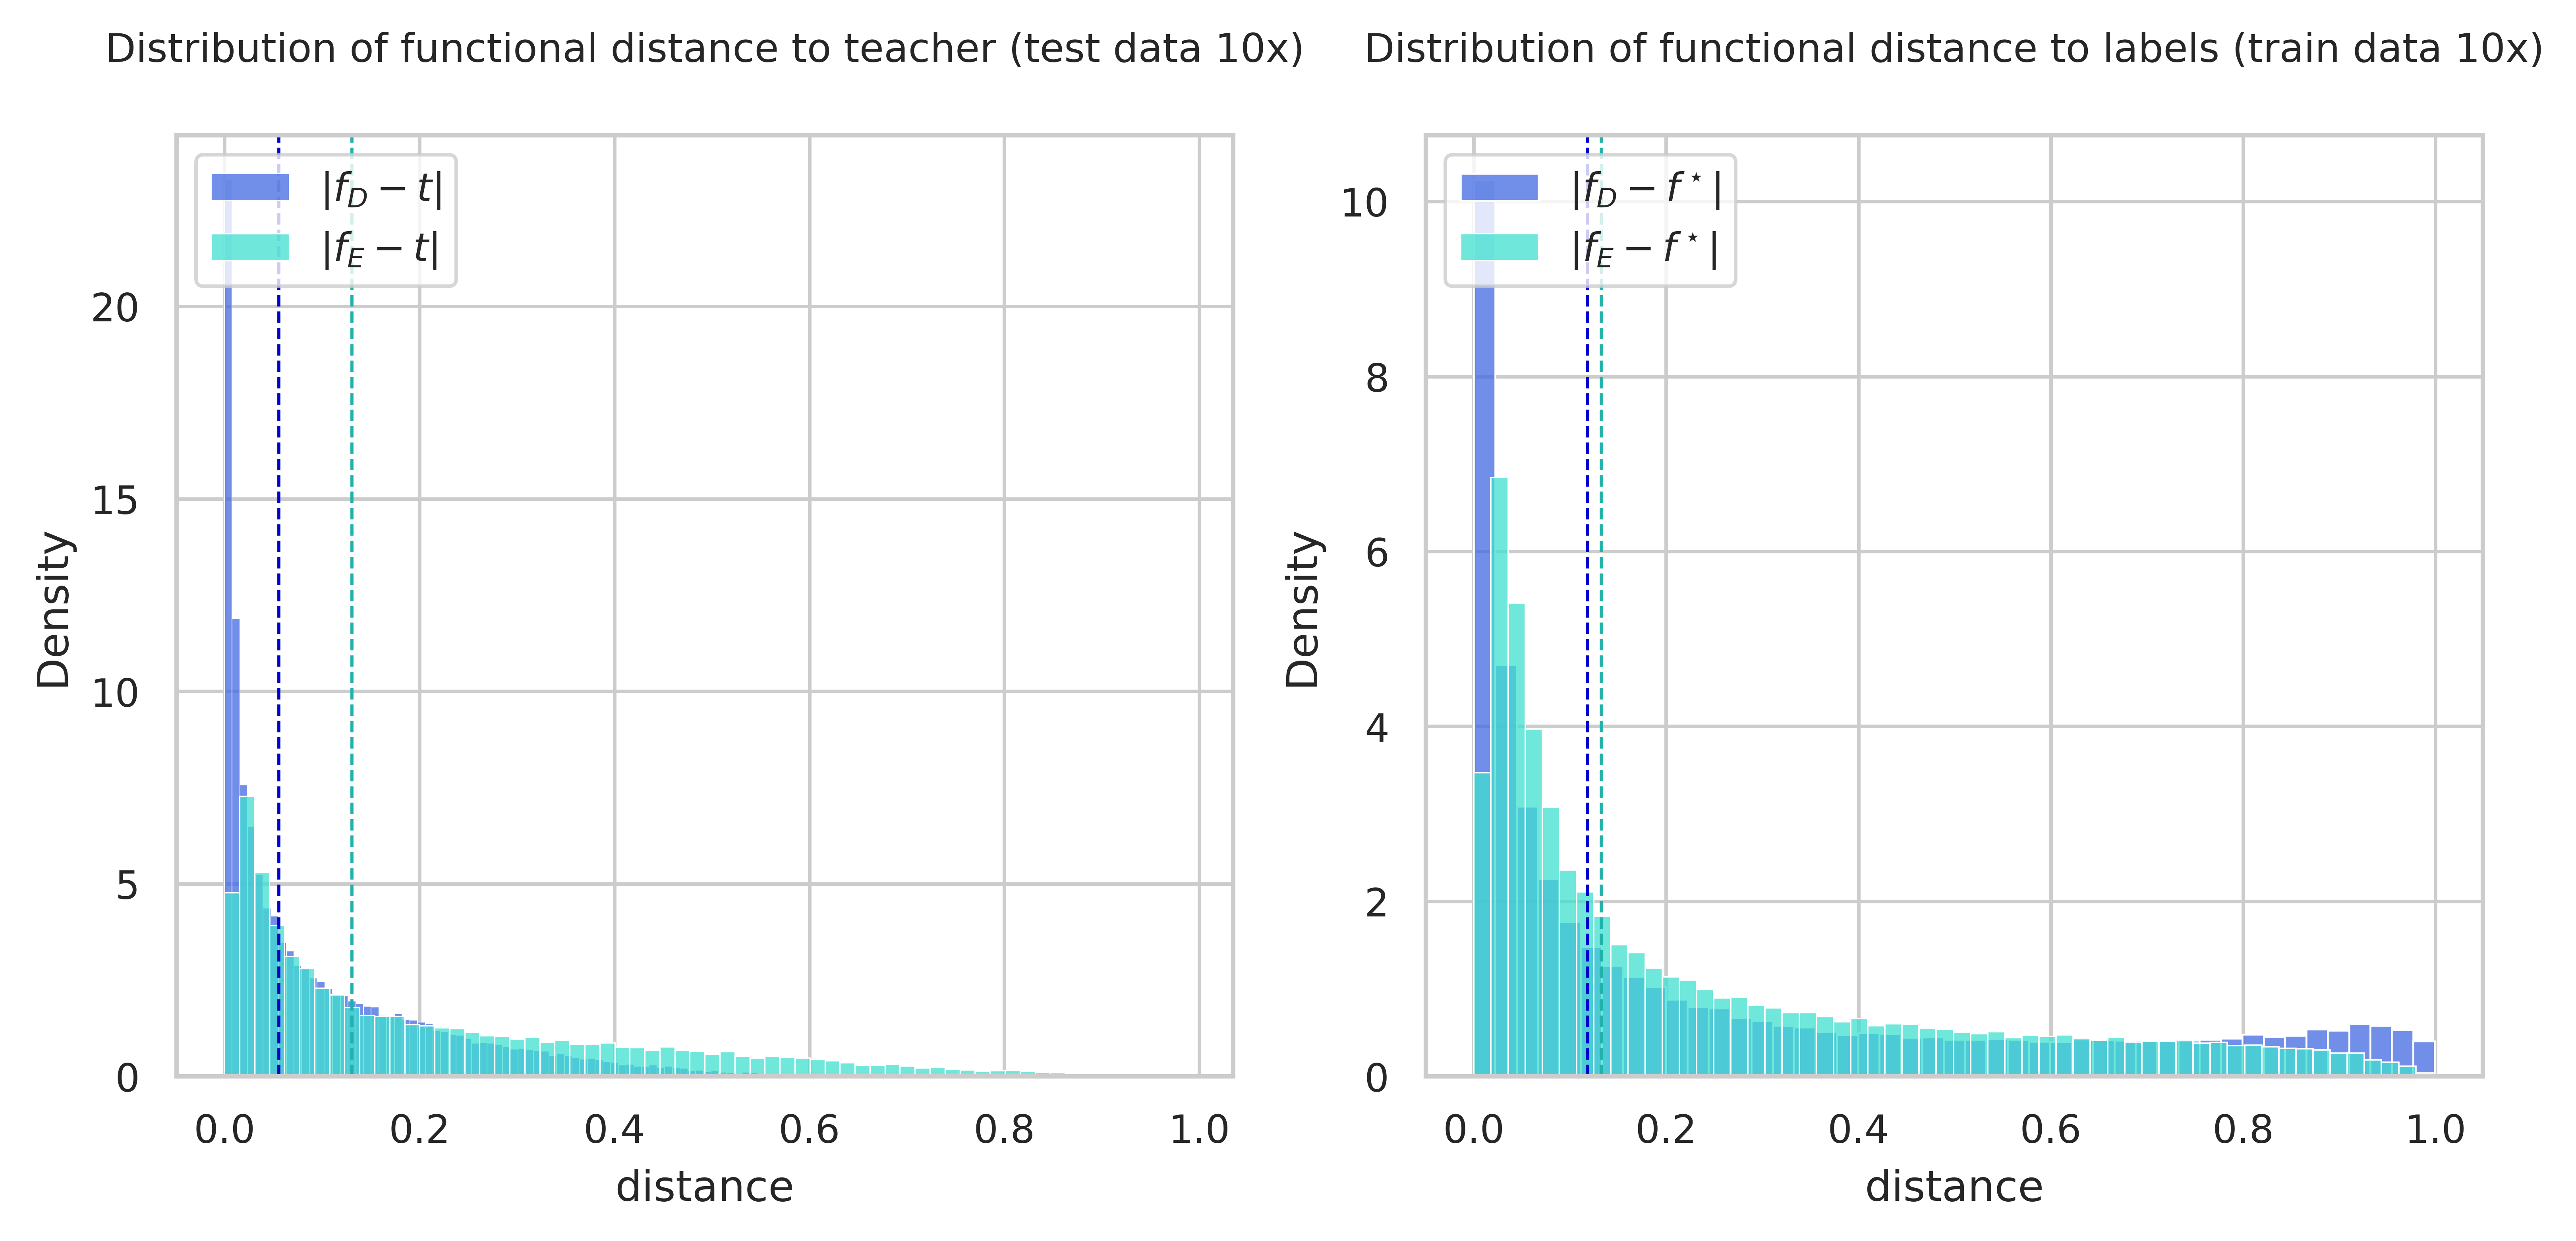

In [11]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==600000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data 10x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==600000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data 10x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


In [21]:
3%4

3

# Train data cifar10

In [12]:
logs_path = './logs/results/cifar5m/mnet/FDIST_cifar10.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

alpha  batch  buffer_size  seed   test  teacher  distance
0          1.0      0       600000    11  False     True  0.064153
1          1.0      0       600000    11  False    False  0.010608
2          1.0      0       600000    11  False     True  0.052135
3          1.0      0       600000    11  False    False  0.060118
4          1.0      0       600000    11  False     True  0.012471
...        ...    ...          ...   ...    ...      ...       ...
2999995    0.0    390        60000    55  False    False  0.368086
2999996    0.0    390        60000    55  False     True  0.006774
2999997    0.0    390        60000    55  False    False  0.012234
2999998    0.0    390        60000    55  False     True  0.008459
2999999    0.0    390        60000    55  False    False  0.009886

[3000000 rows x 7 columns]

In [14]:
res_df['buffer_size'].unique()

array([600000, 120000,  60000])

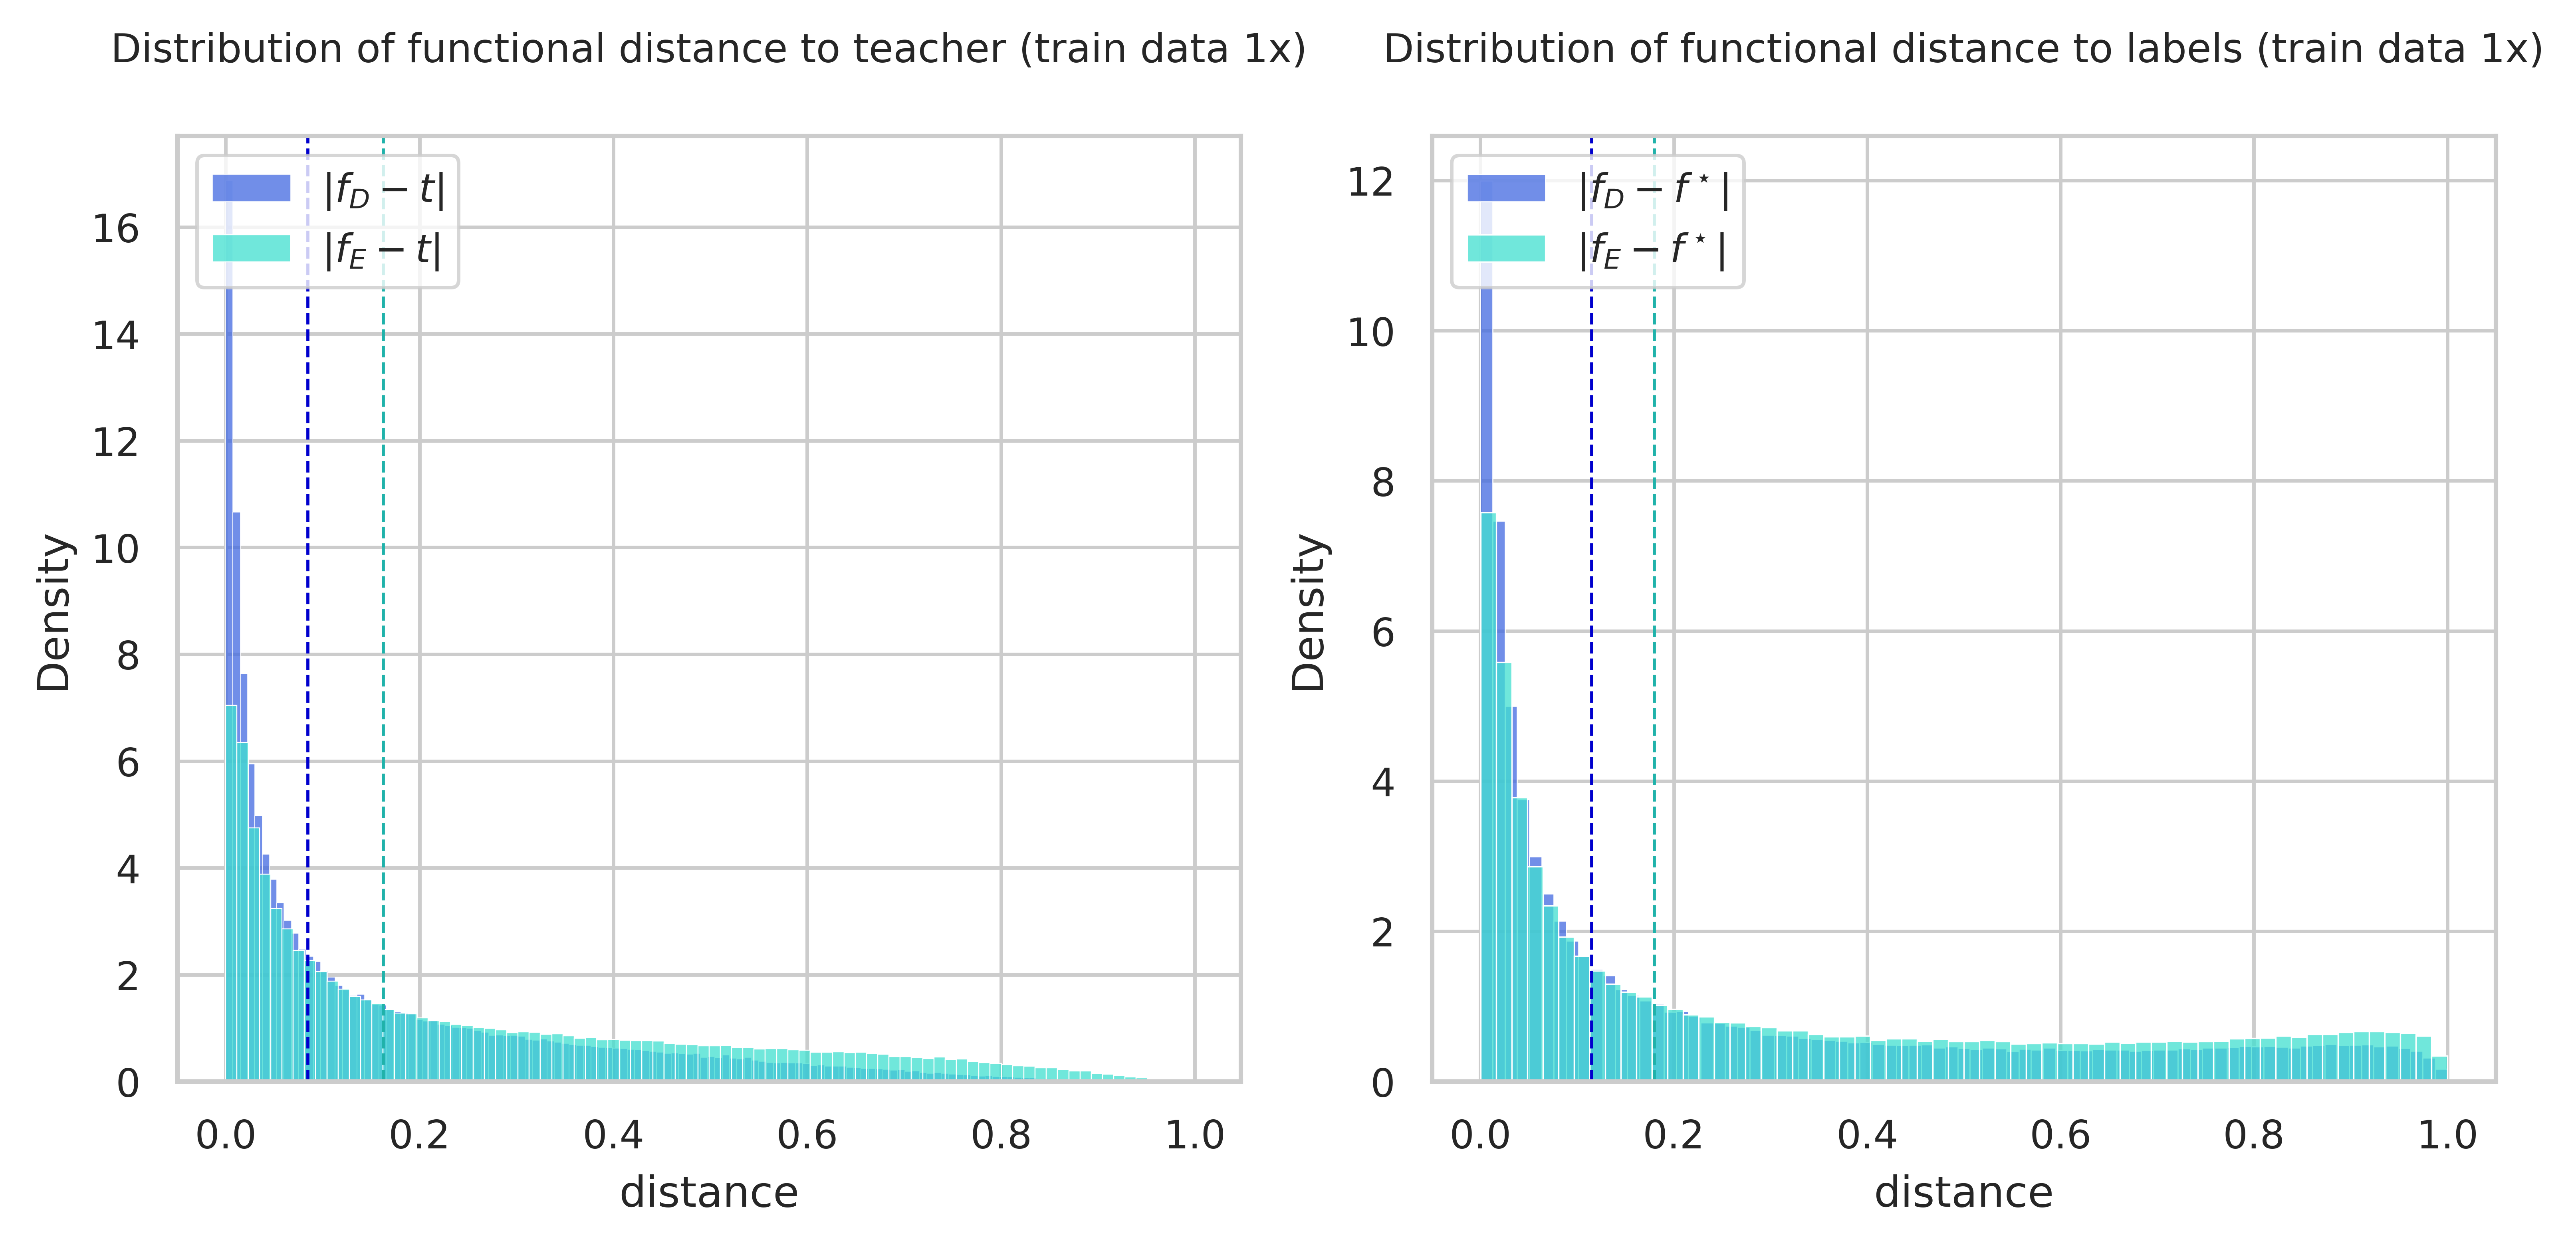

In [15]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==60000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (train data 1x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==60000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data 1x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


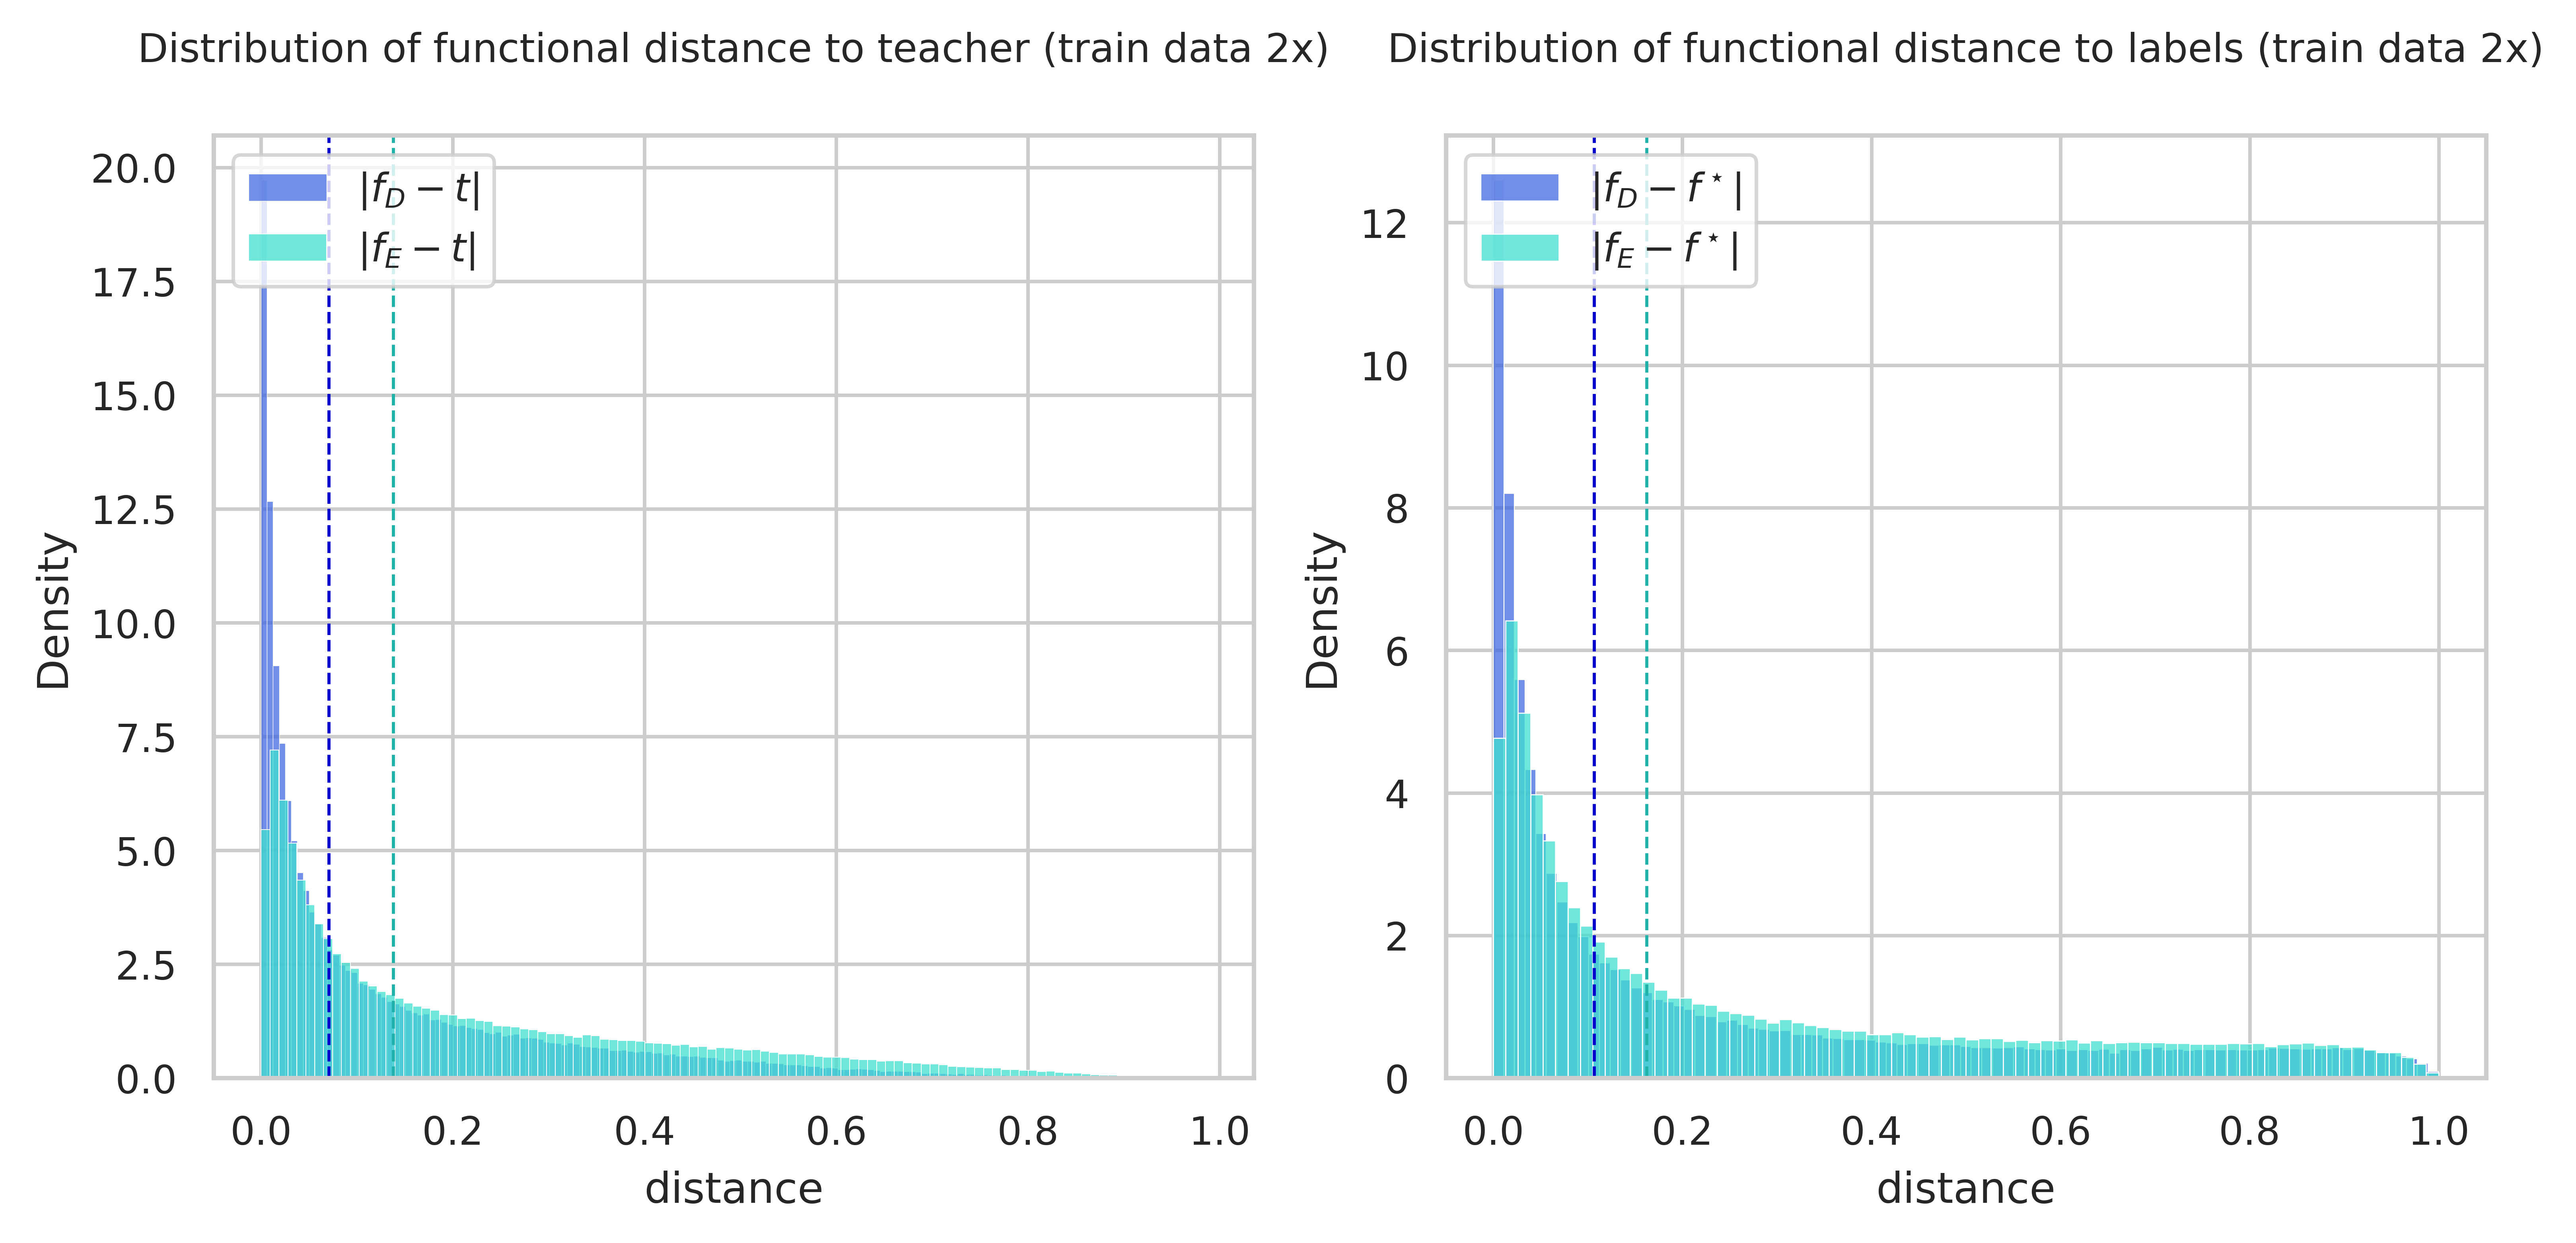

In [16]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==120000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (train data 2x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==120000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data 2x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()


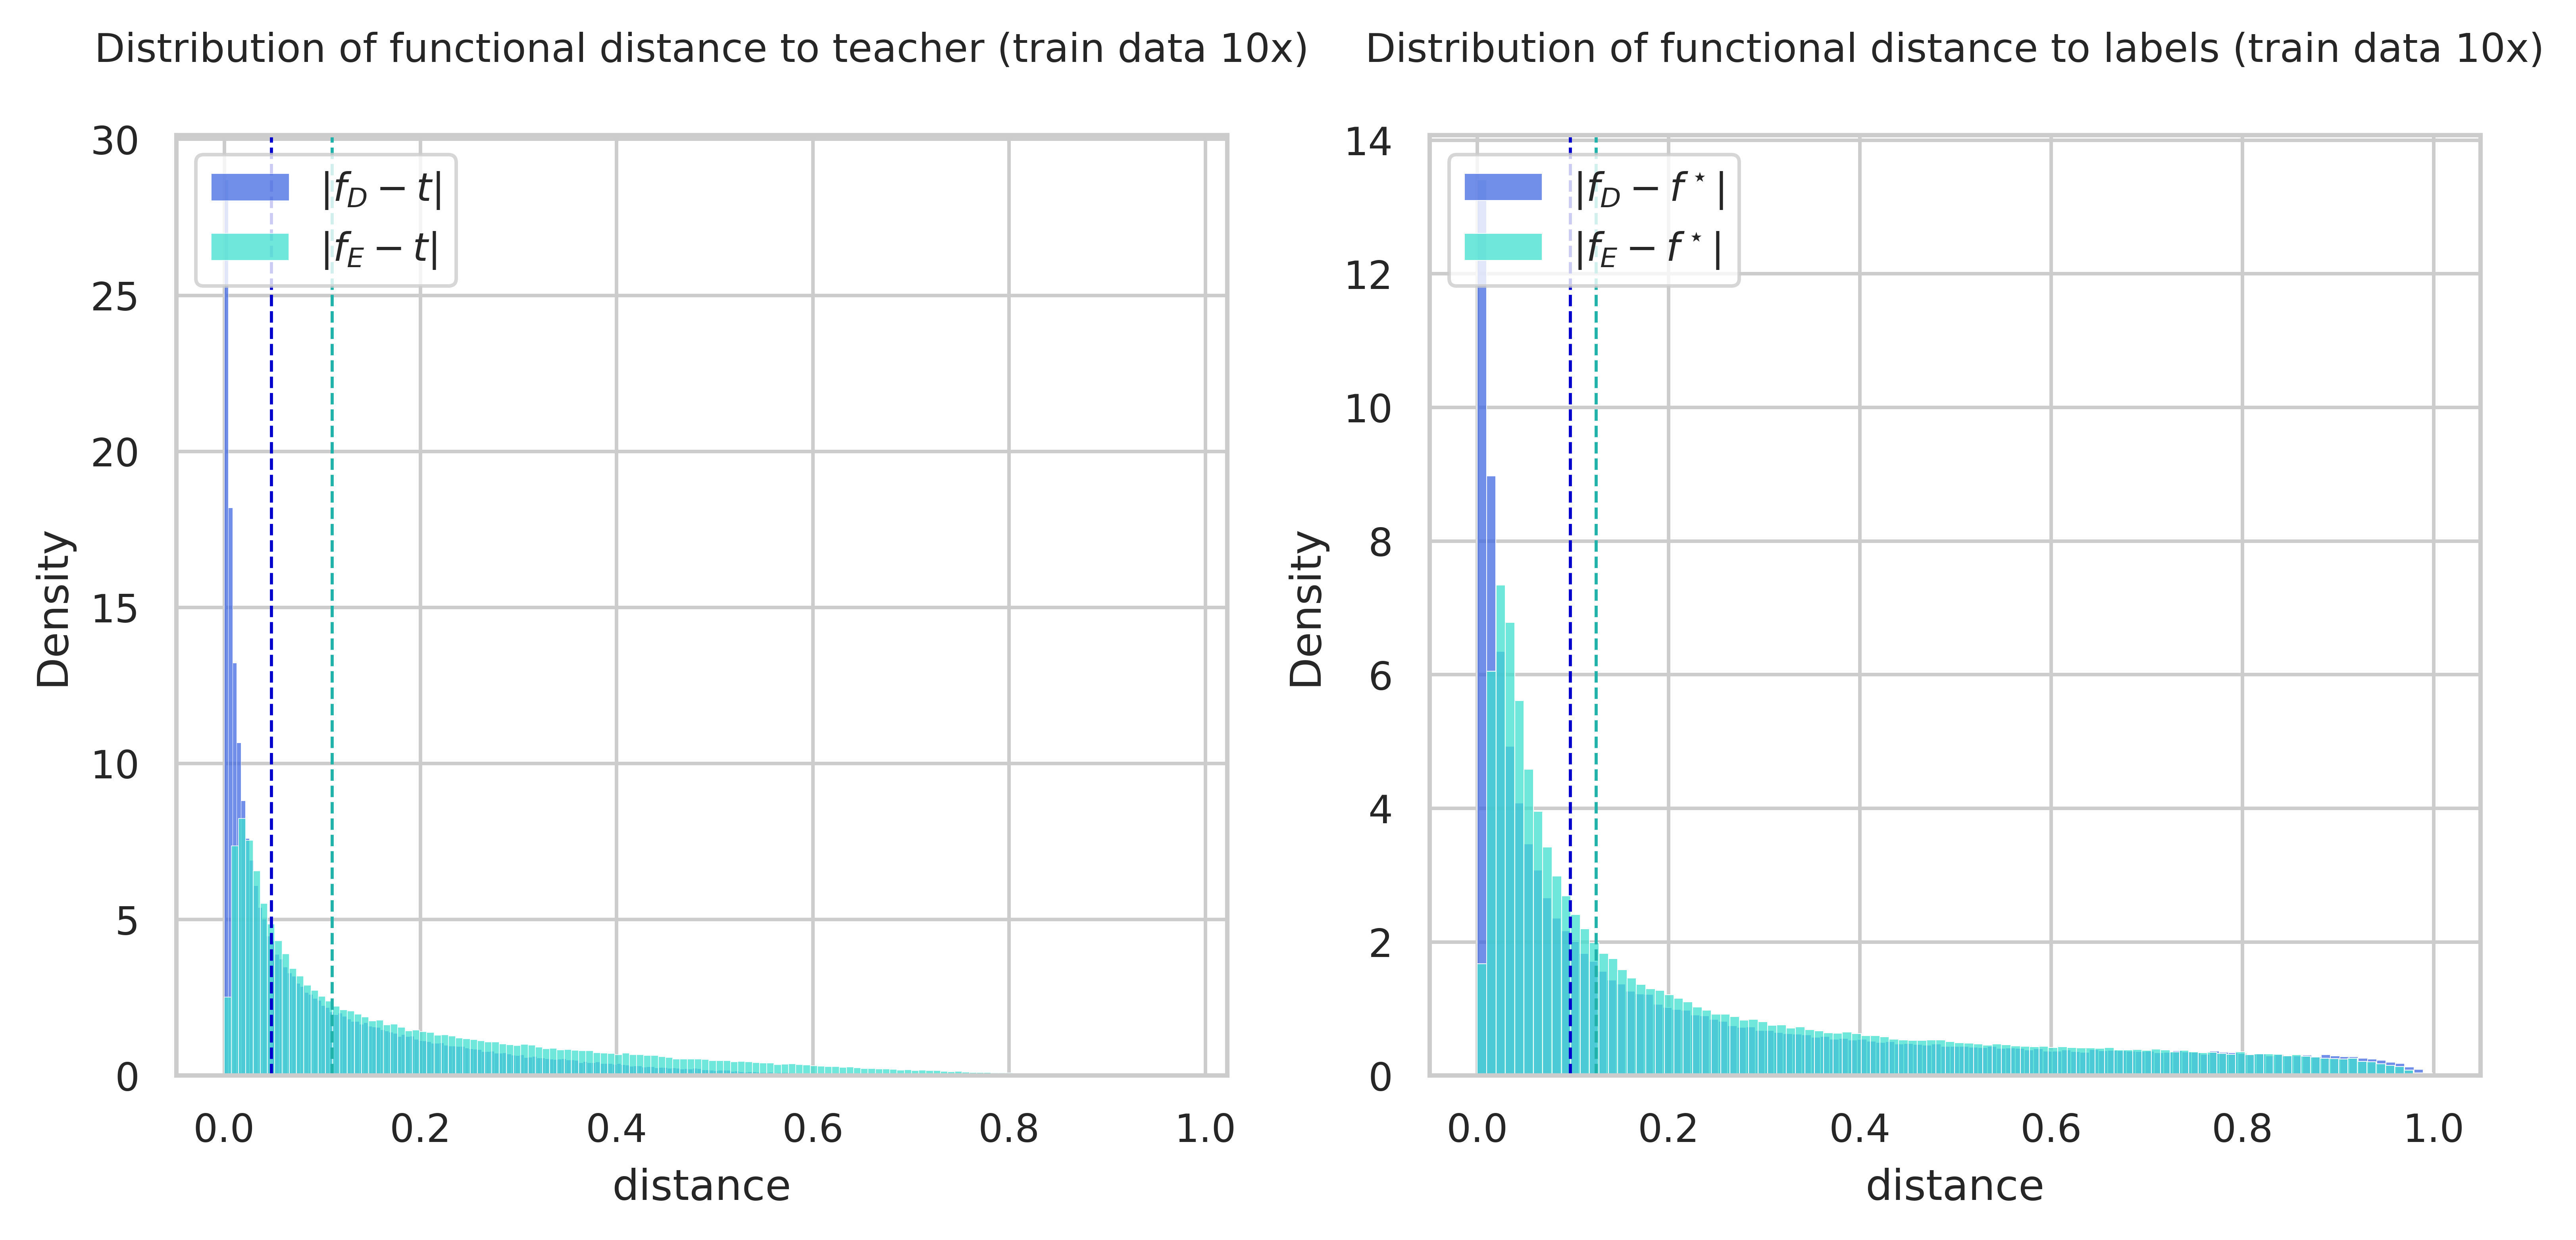

In [17]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','mediumblue','lightseagreen','khaki','darkkhaki']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]
    _df = _df.loc[_df['buffer_size']==600000]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (train data 10x)", fontsize=9, y=1.05)
    
    
    ax[0].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[0].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]
    _df = _df.loc[_df['buffer_size']==600000]


    # sns.histplot(teacher_df_train, x="distance", ax=ax[1], color=colors[4], label="t", stat="density", bins=100)
    # ax[1].axvline(teacher_df_train['distance'].median(), ls='--', color=colors[5], linewidth=0.7)


    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (train data 10x)", fontsize=9, y=1.05)
    
    ax[1].axvline(_df1['distance'].median(), ls='--', color=colors[2], linewidth=0.7)
    ax[1].axvline(_df2['distance'].median(), ls='--', color=colors[3], linewidth=0.7)

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper left")

    plt.tight_layout()
